In [76]:
import calendar
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

In [74]:
def process_1file(filename):
    # TODO:....
    df = pd.read_csv(path+filename)
    df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'])
    df.set_index('Timestamp (UTC+07:00)', inplace=True)
    
    start_date = df.index.min()
    start_year = start_date.year
    start_date_may_1st = pd.Timestamp(year=start_year, month=5, day=1)
    end_date = df.index.max()
    end_year = end_date.year
    end_date_april_30 = pd.Timestamp(year=end_year, month=4, day=30)

    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    df1 = df.reindex(full_date_range) # fill missing dates' values with NaN
    # df1['Value'] = df1['Value'].interpolate(method='linear')
    
    df2 = df1[~((df1.index.month == 2) & (df1.index.day == 29))]
    df3 = df2.loc[start_date_may_1st:end_date_april_30]
    
    
    Q_list = df3['Value'].values
    Q_Mat = Q_list.reshape((365, -1), order='F')


    fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))
    dd = np.arange(1,366)

    
    # ax.plot(dd, Q_Mat[:,-2],color='r',lw=1,label='2019')
    ax.plot(dd,np.nanmean(Q_Mat,axis=1),lw=1,ls='--',color='black', label='Multi-year Average')
    ax.fill_between(dd, np.nanpercentile(Q_Mat,q=5,axis=1),np.nanpercentile(Q_Mat,q=95,axis=1), color='#BDD7EE',alpha=1,label='Q5~Q95')
    ax.fill_between(dd, np.nanpercentile(Q_Mat,q=25,axis=1),np.nanpercentile(Q_Mat,q=75,axis=1), color='#599AD7',alpha=1,label='Q25~Q75')

    
    ax.set_xticks([1,31,61,92,123,153,184,214,245,276,304,335])
    ax.set_xticklabels(['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr'])

    ax.set_ylabel('Discharge (m^3/s)')
    ax.set_xlabel('Month')
    
    figname = filename.replace('.csv','')
    ax.set_title(figname)
    ax.set_xlim(dd[0], dd[-1])

    ax.legend()
    
    plt.show()
    # figname1 = filename.replace('.csv','.png')
    # plt.savefig(path+figname1)

    return 

In [61]:
path = 'D:/LMRB/discharge/MRC/mainstream/'
filelist = os.listdir(path)
filelist

['Chiang Khan.csv',
 'Chiang Saen.csv',
 'Khong Chiam.csv',
 'Kratie.csv',
 'Luang Prabang.csv',
 'Mukdahan.csv',
 'Nakhon Phanom.csv',
 'Nong Khai.csv',
 'Pakse.csv',
 'Stung Treng.csv']

Chiang Khan.csv


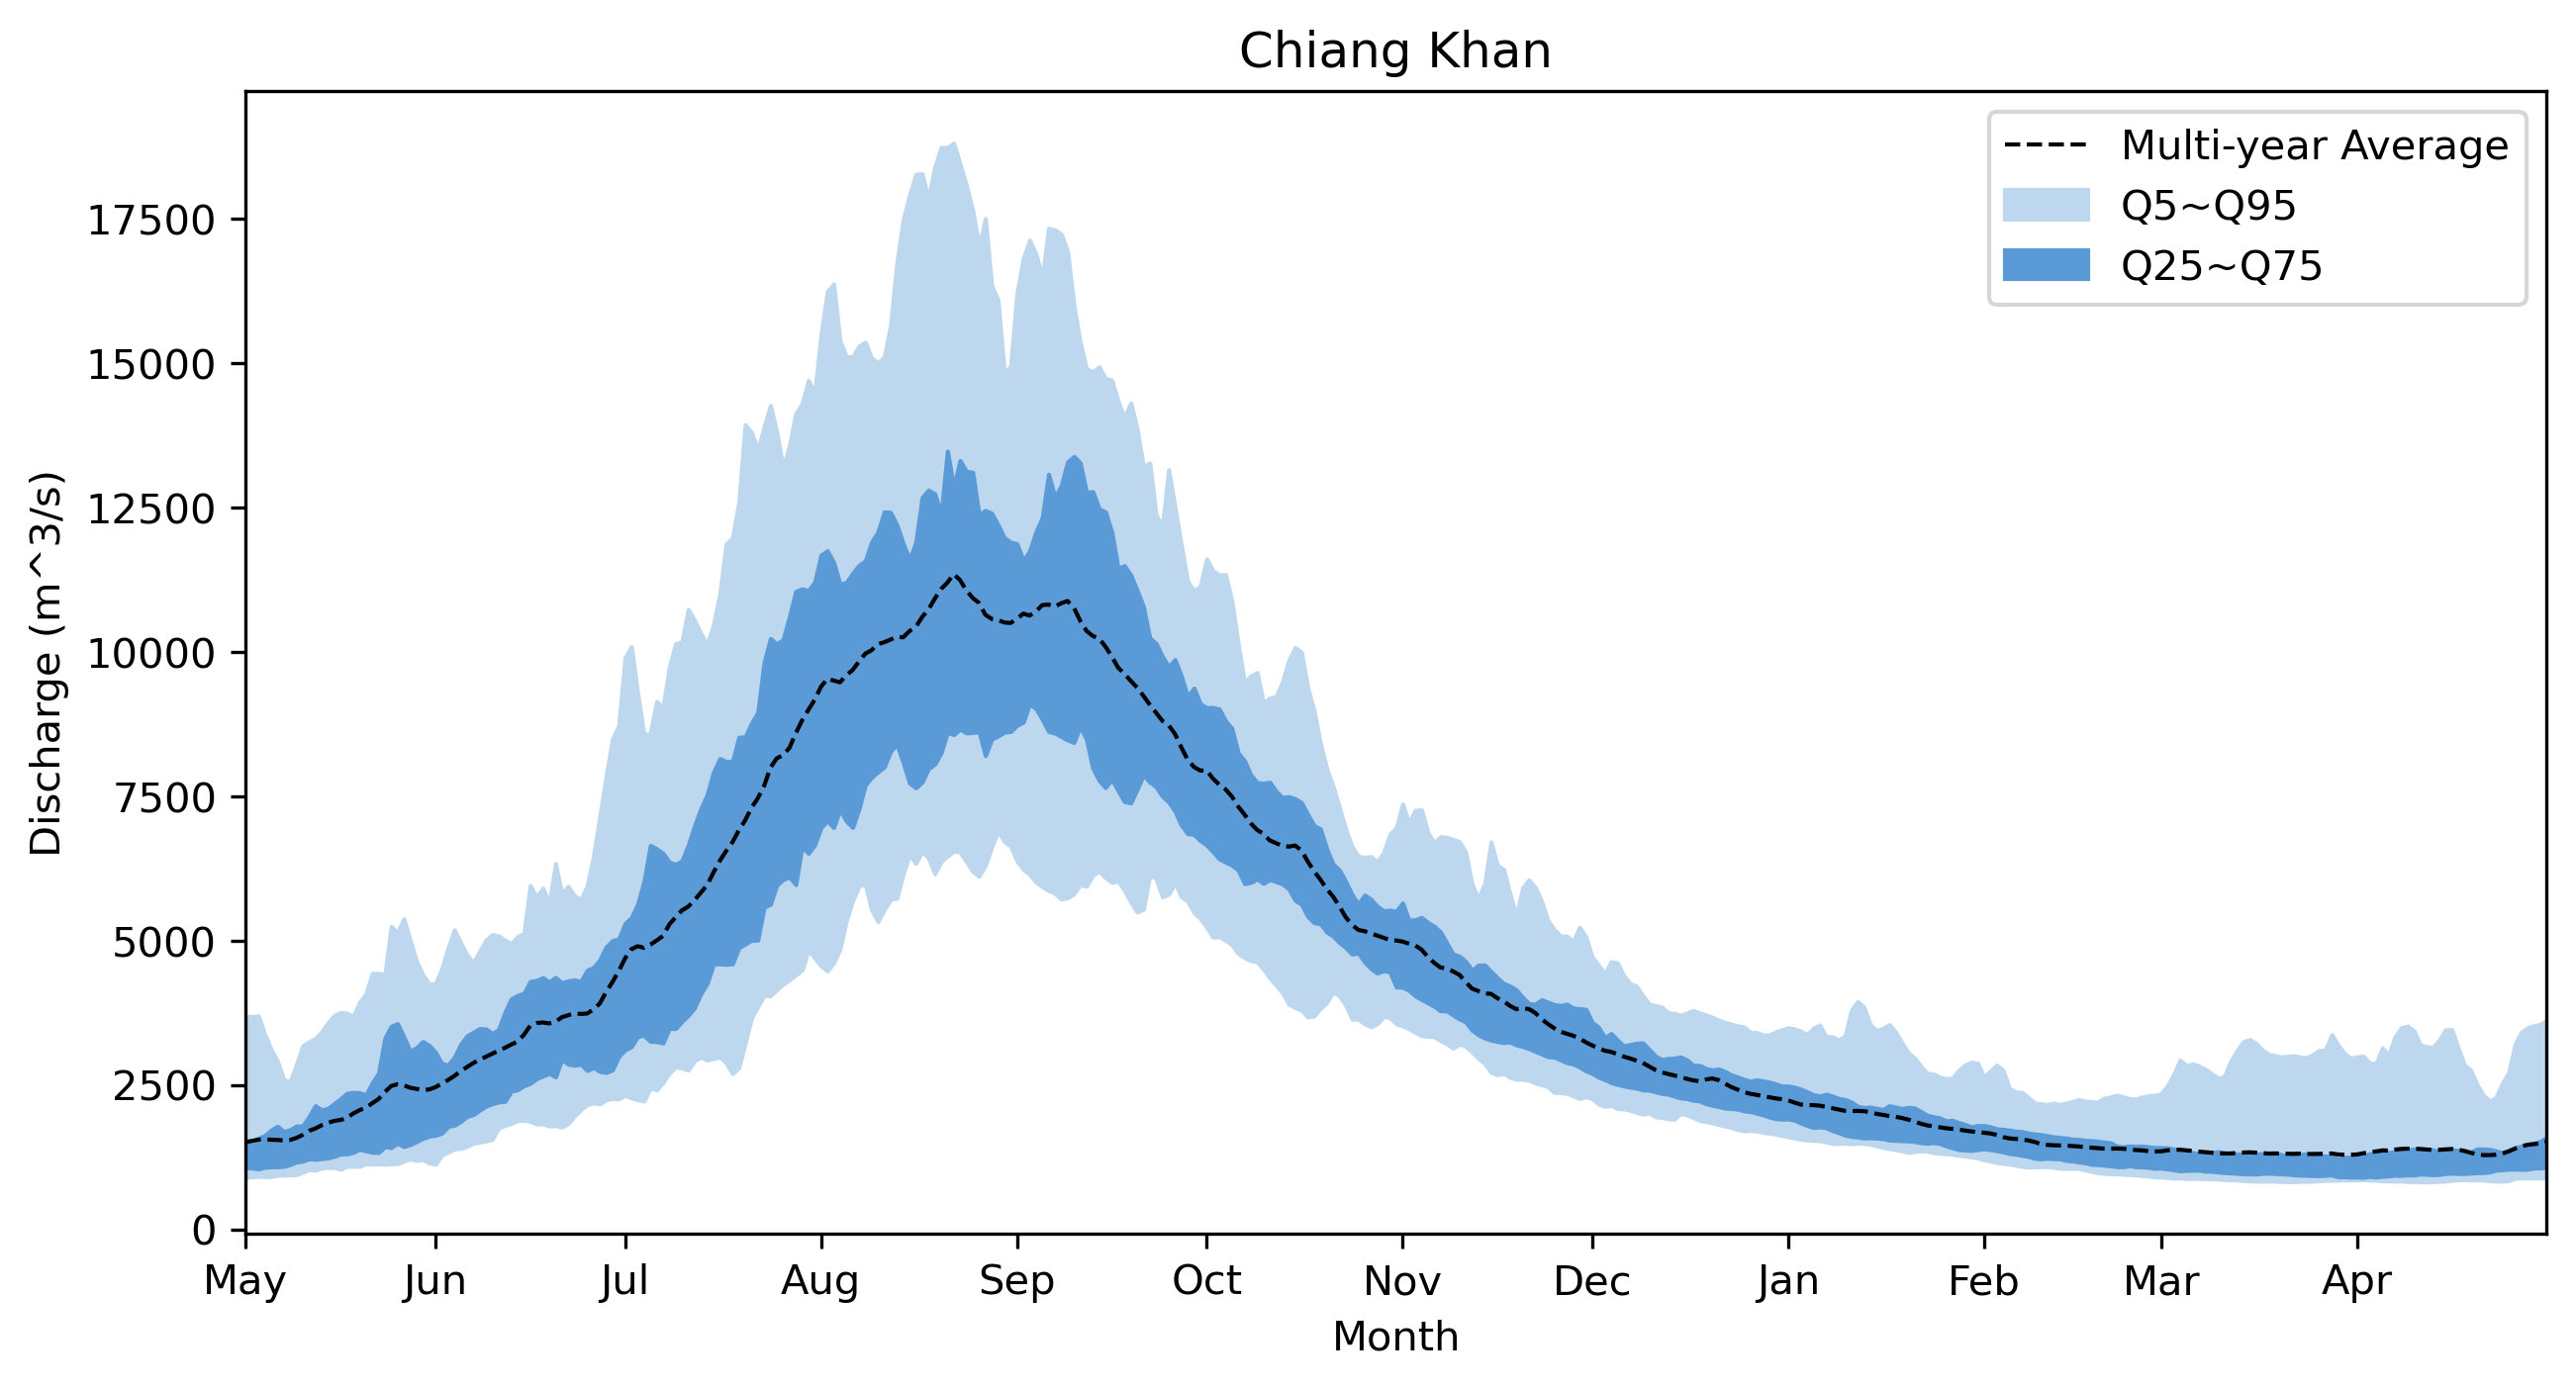

Chiang Saen.csv


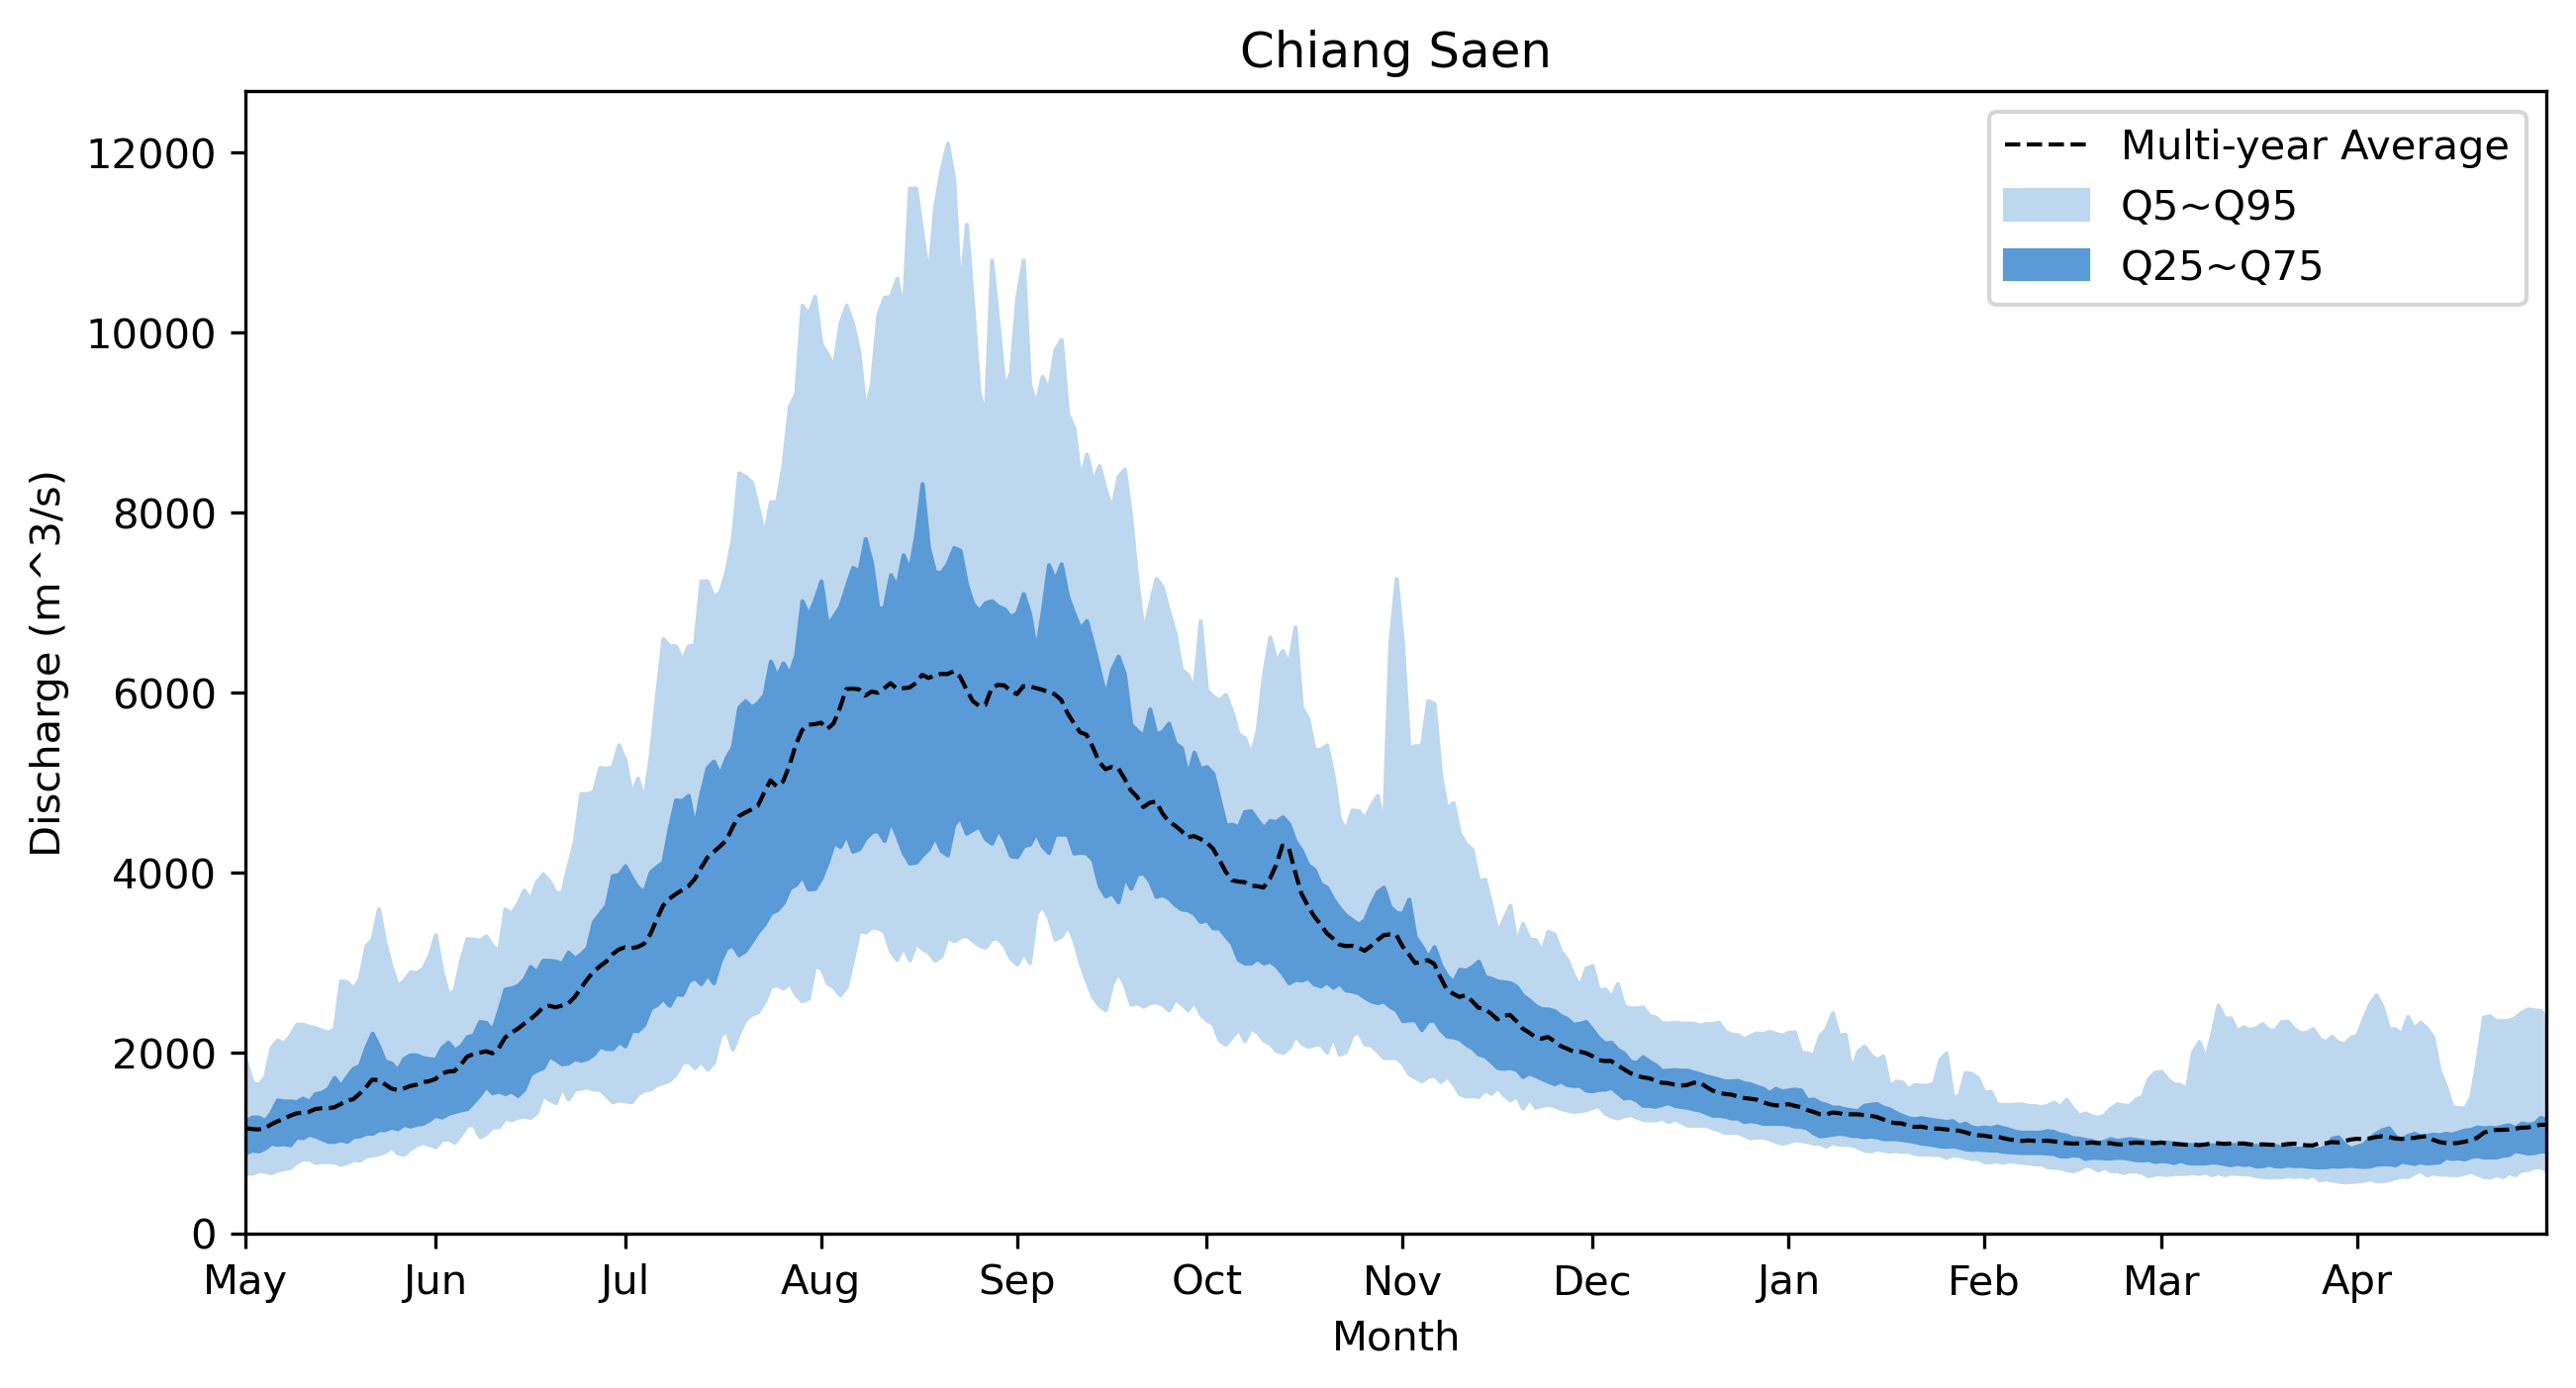

Khong Chiam.csv


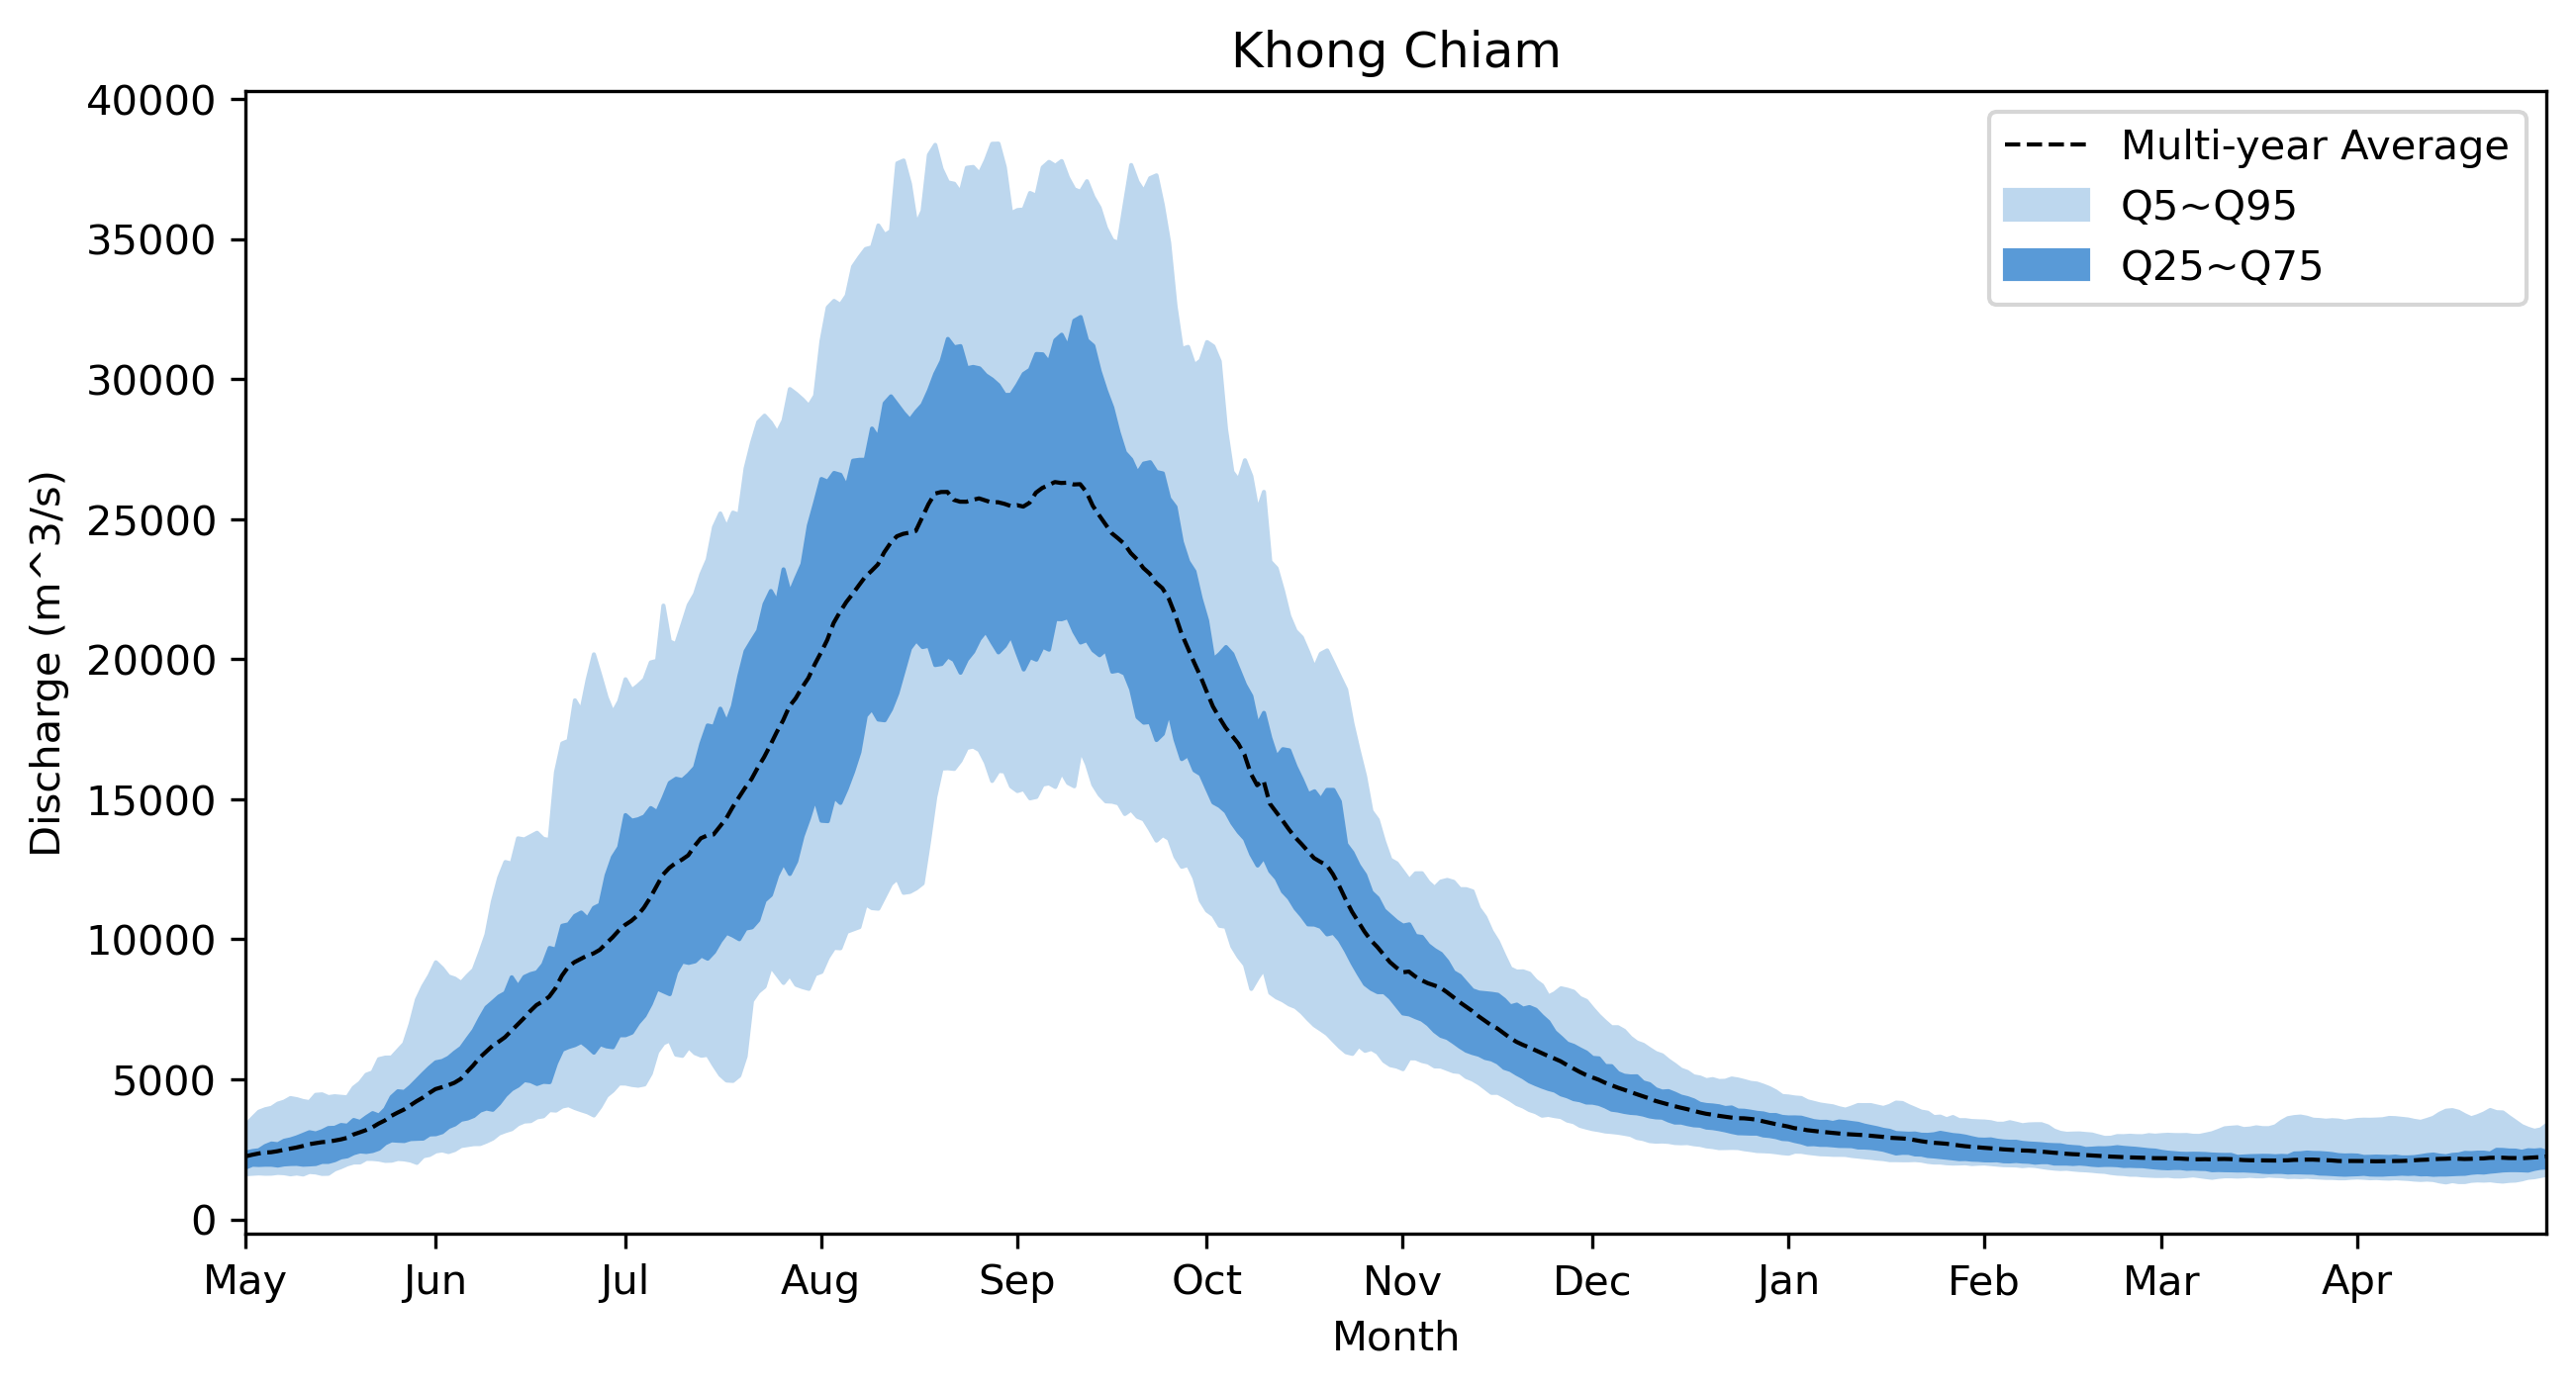

Kratie.csv


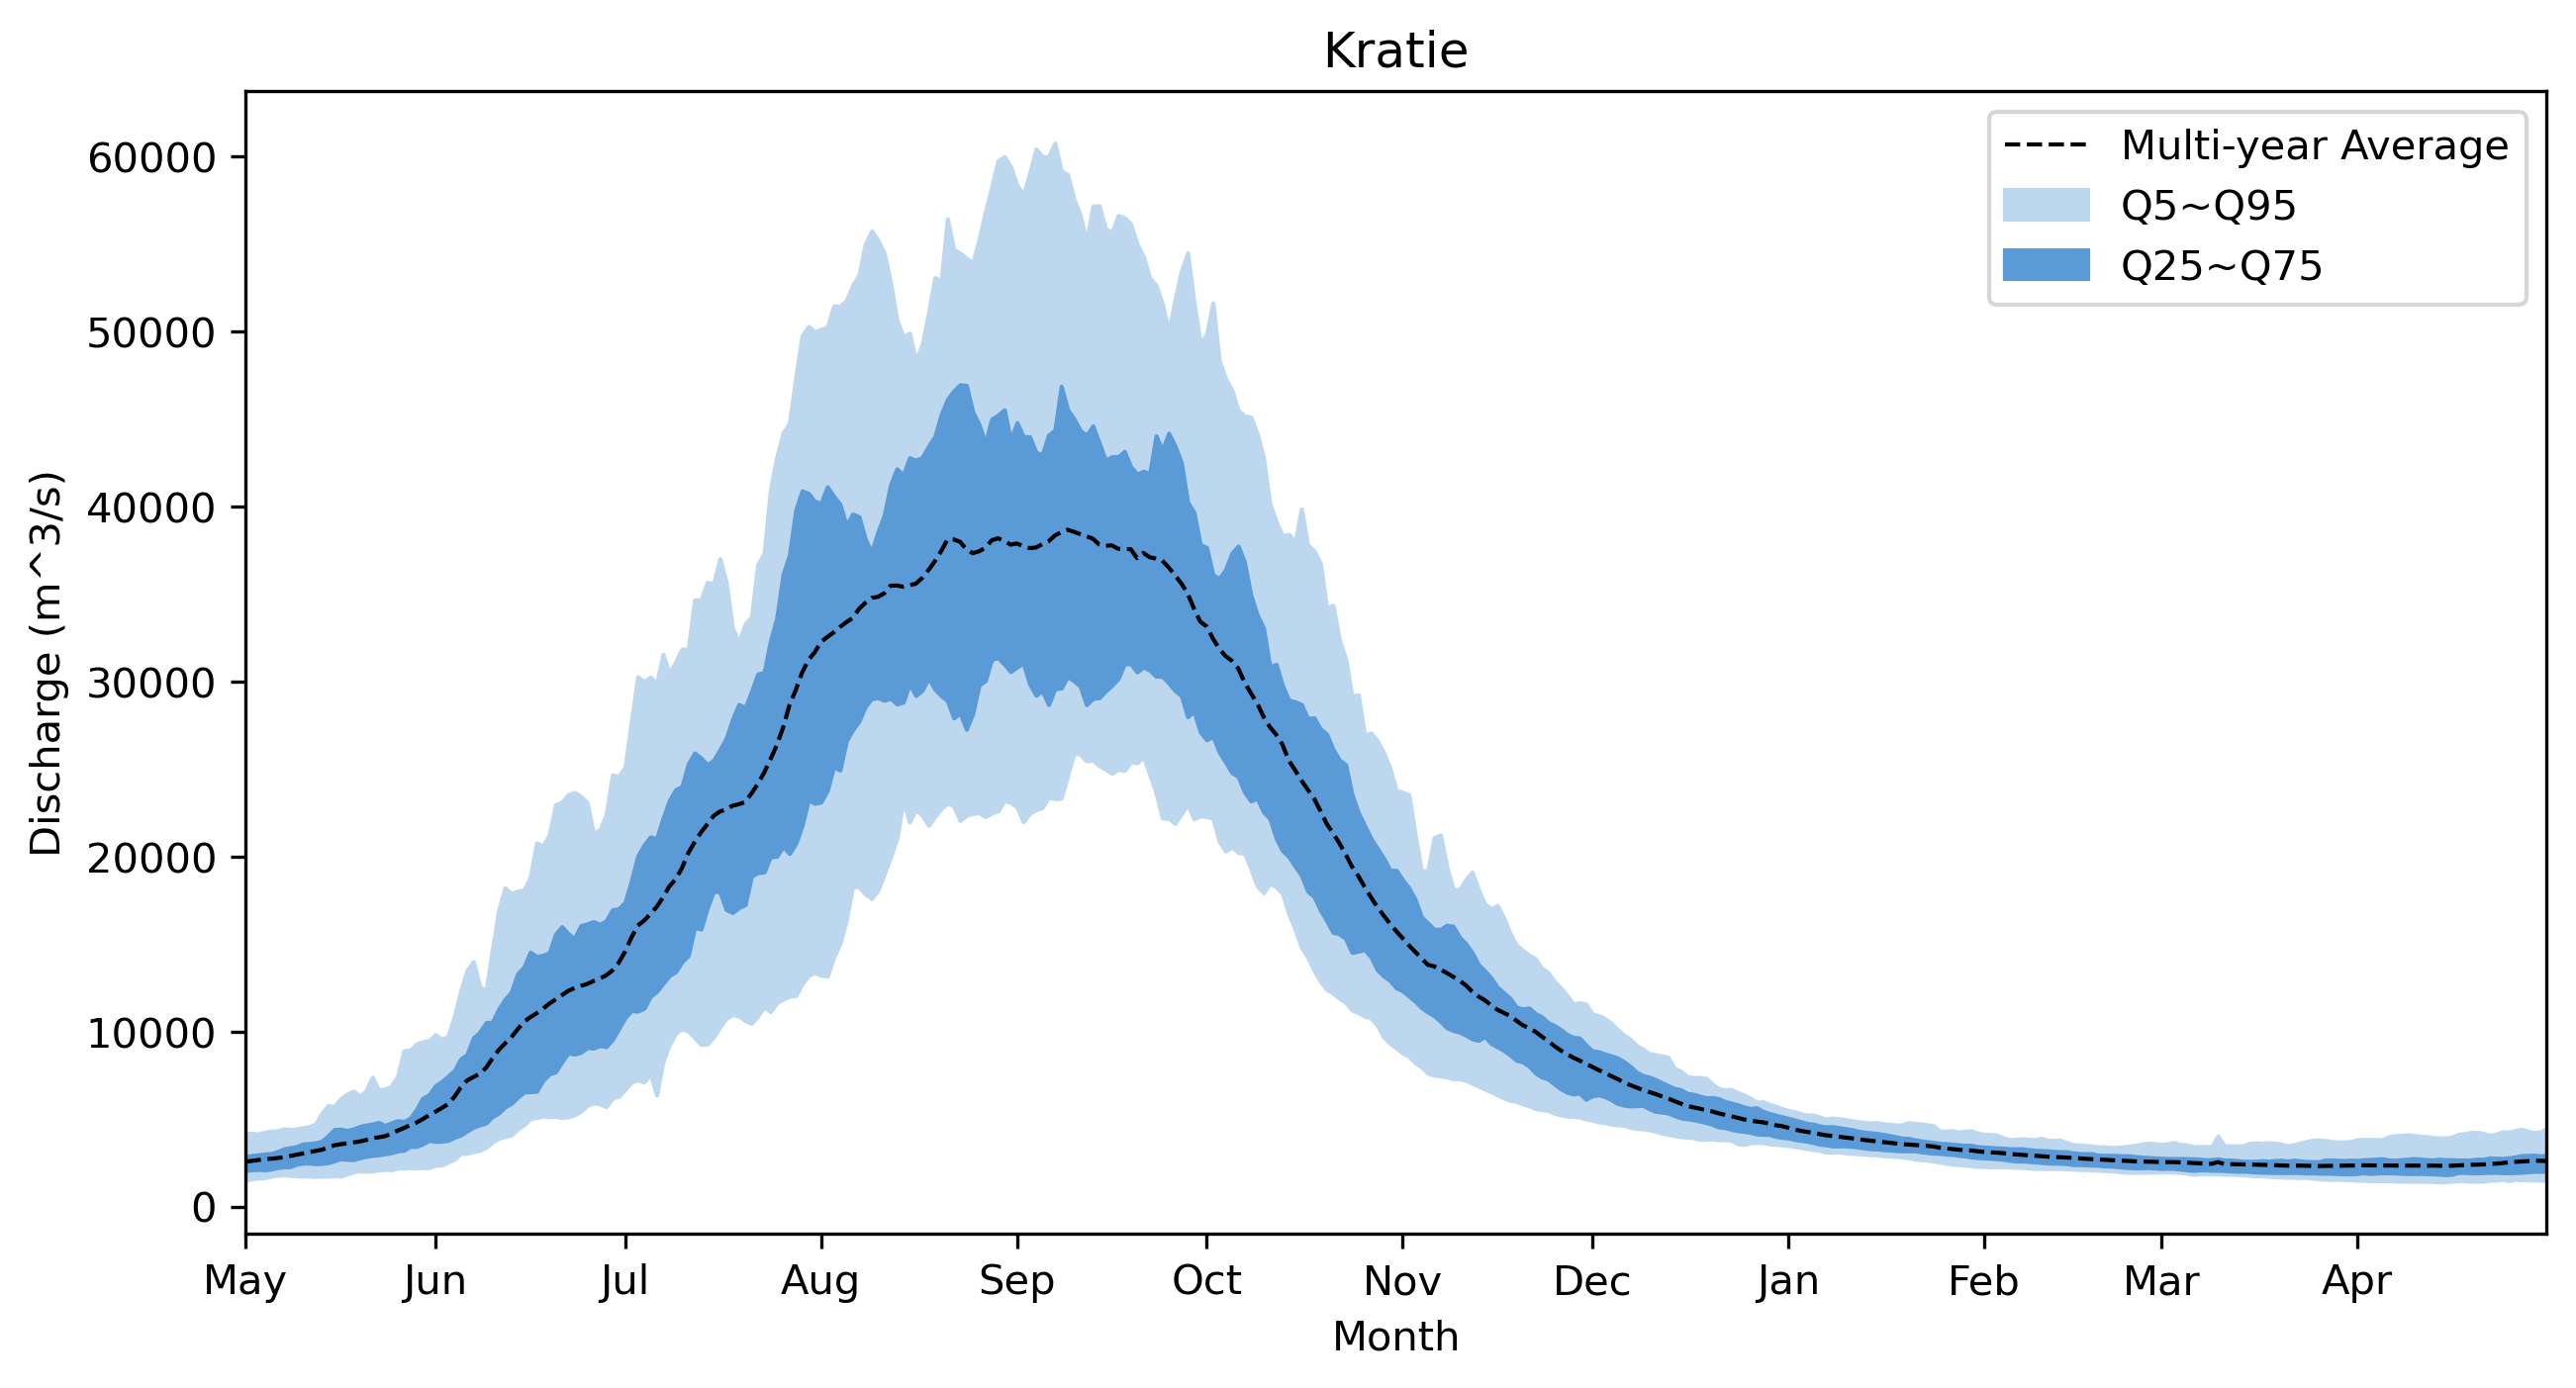

Luang Prabang.csv


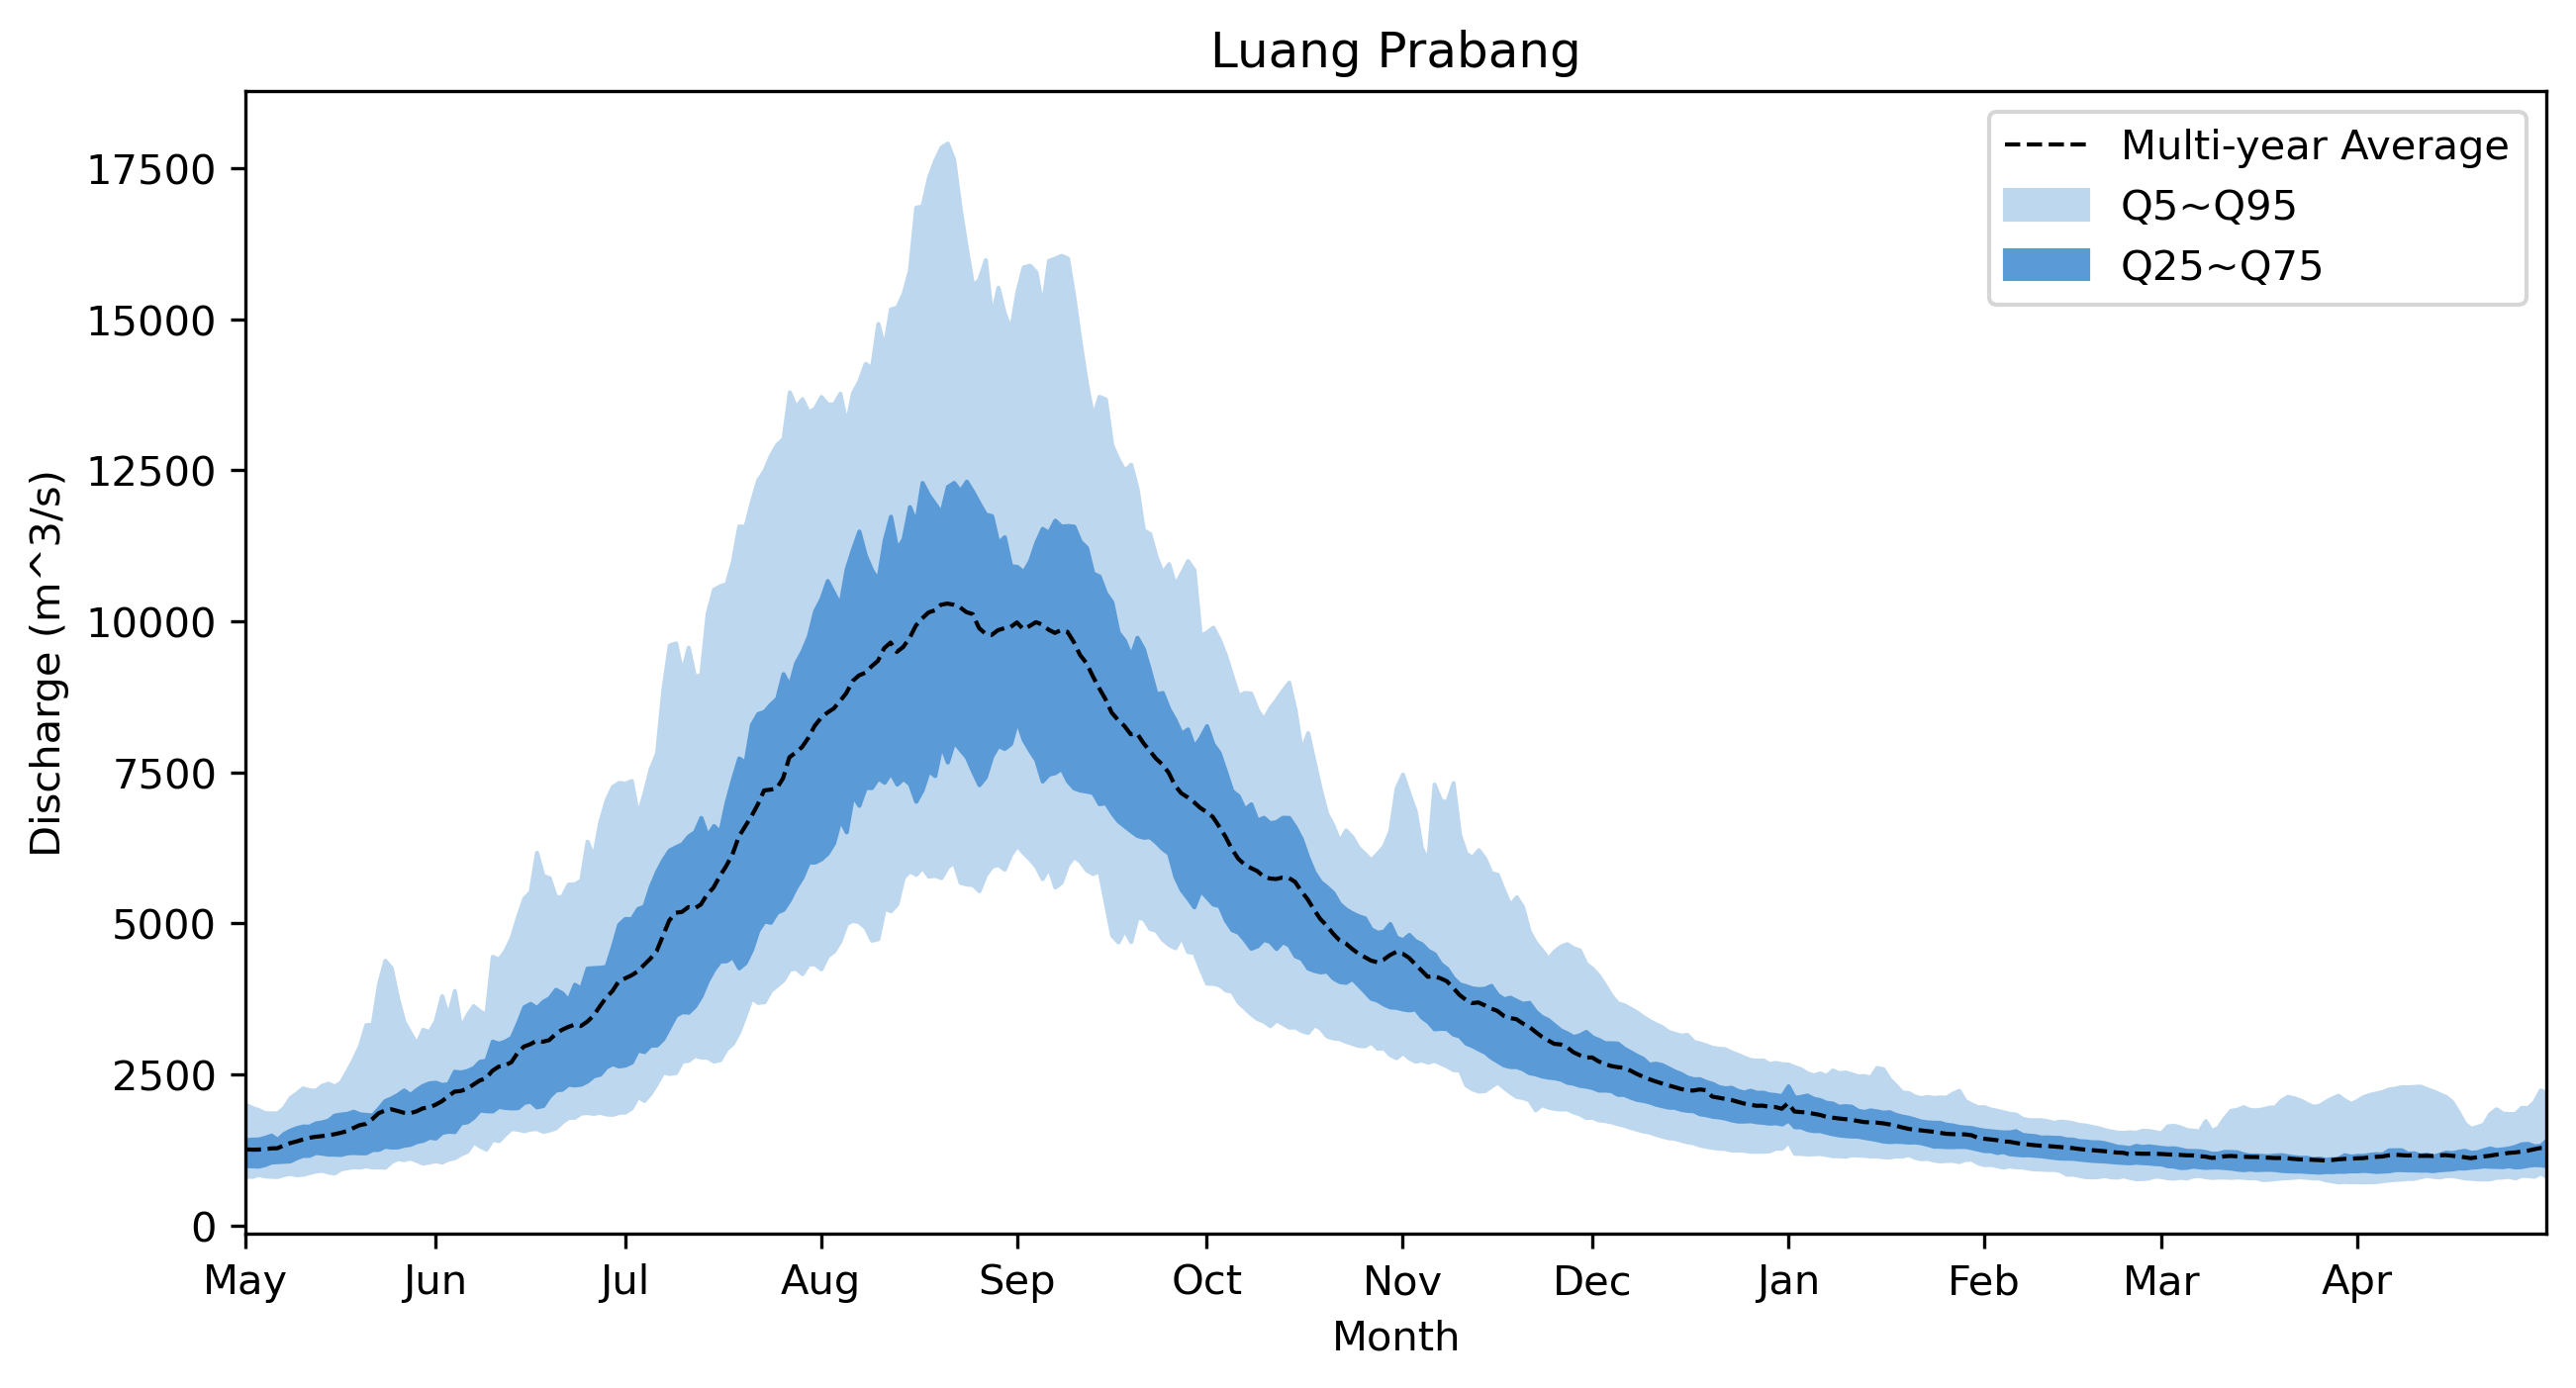

Mukdahan.csv


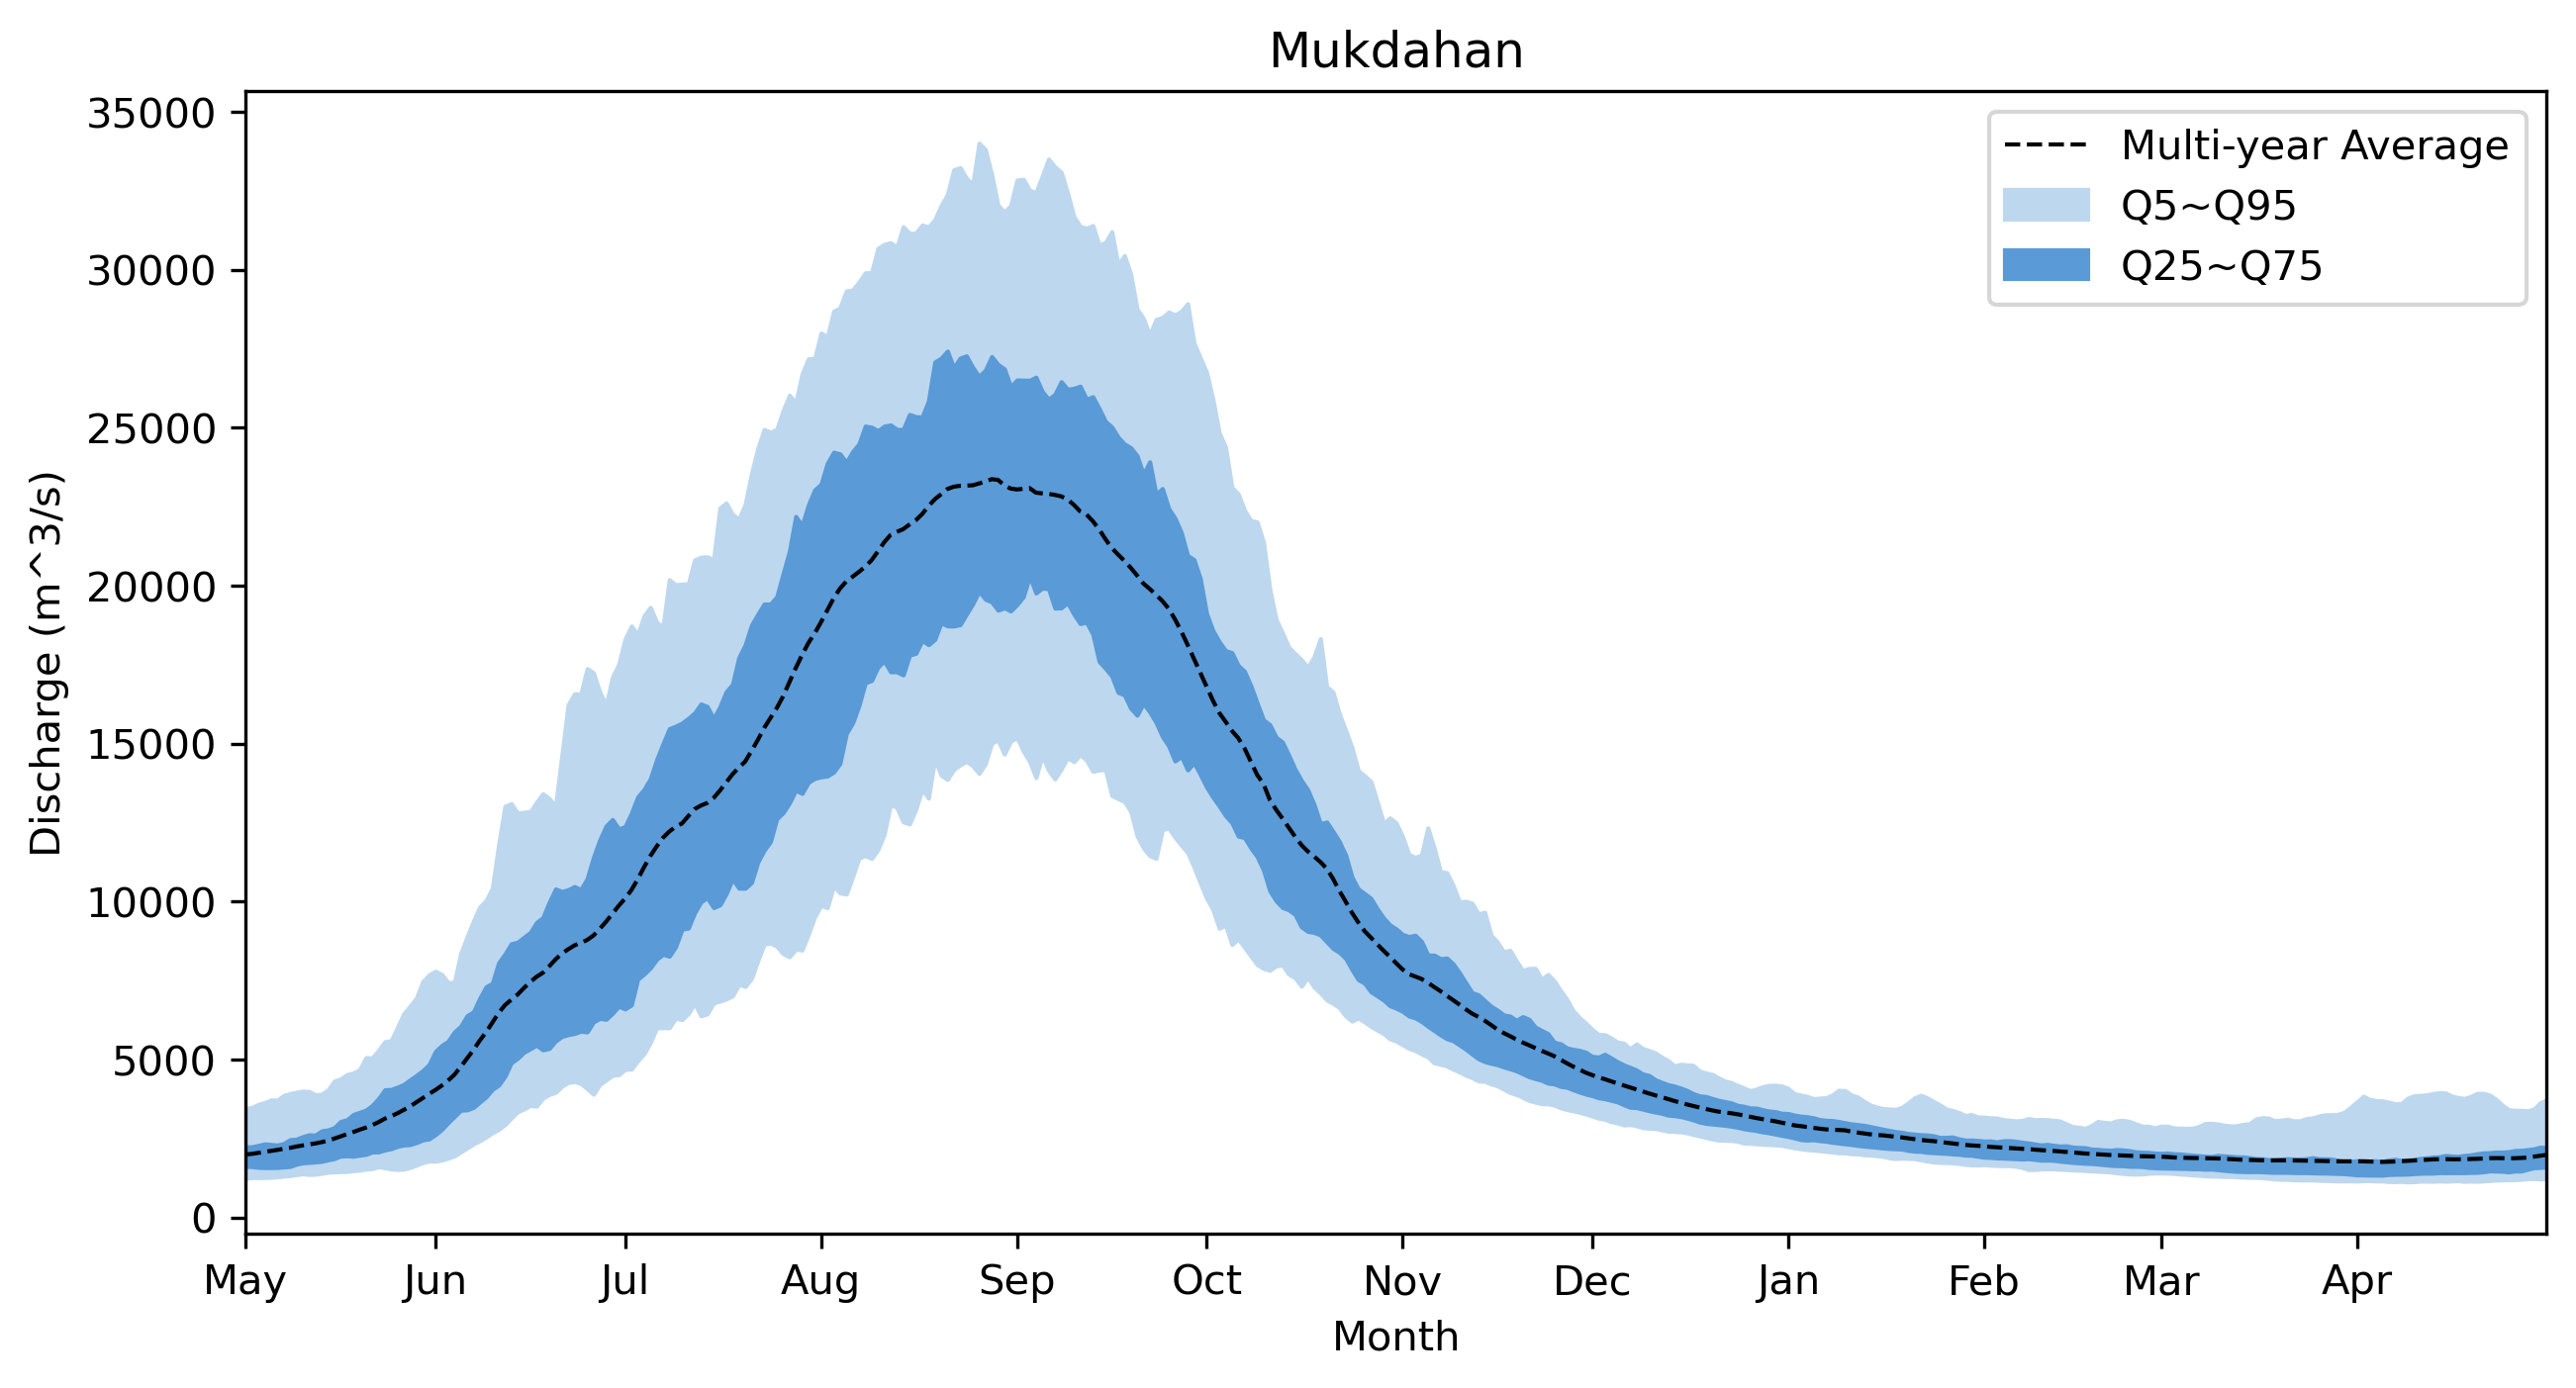

Nakhon Phanom.csv


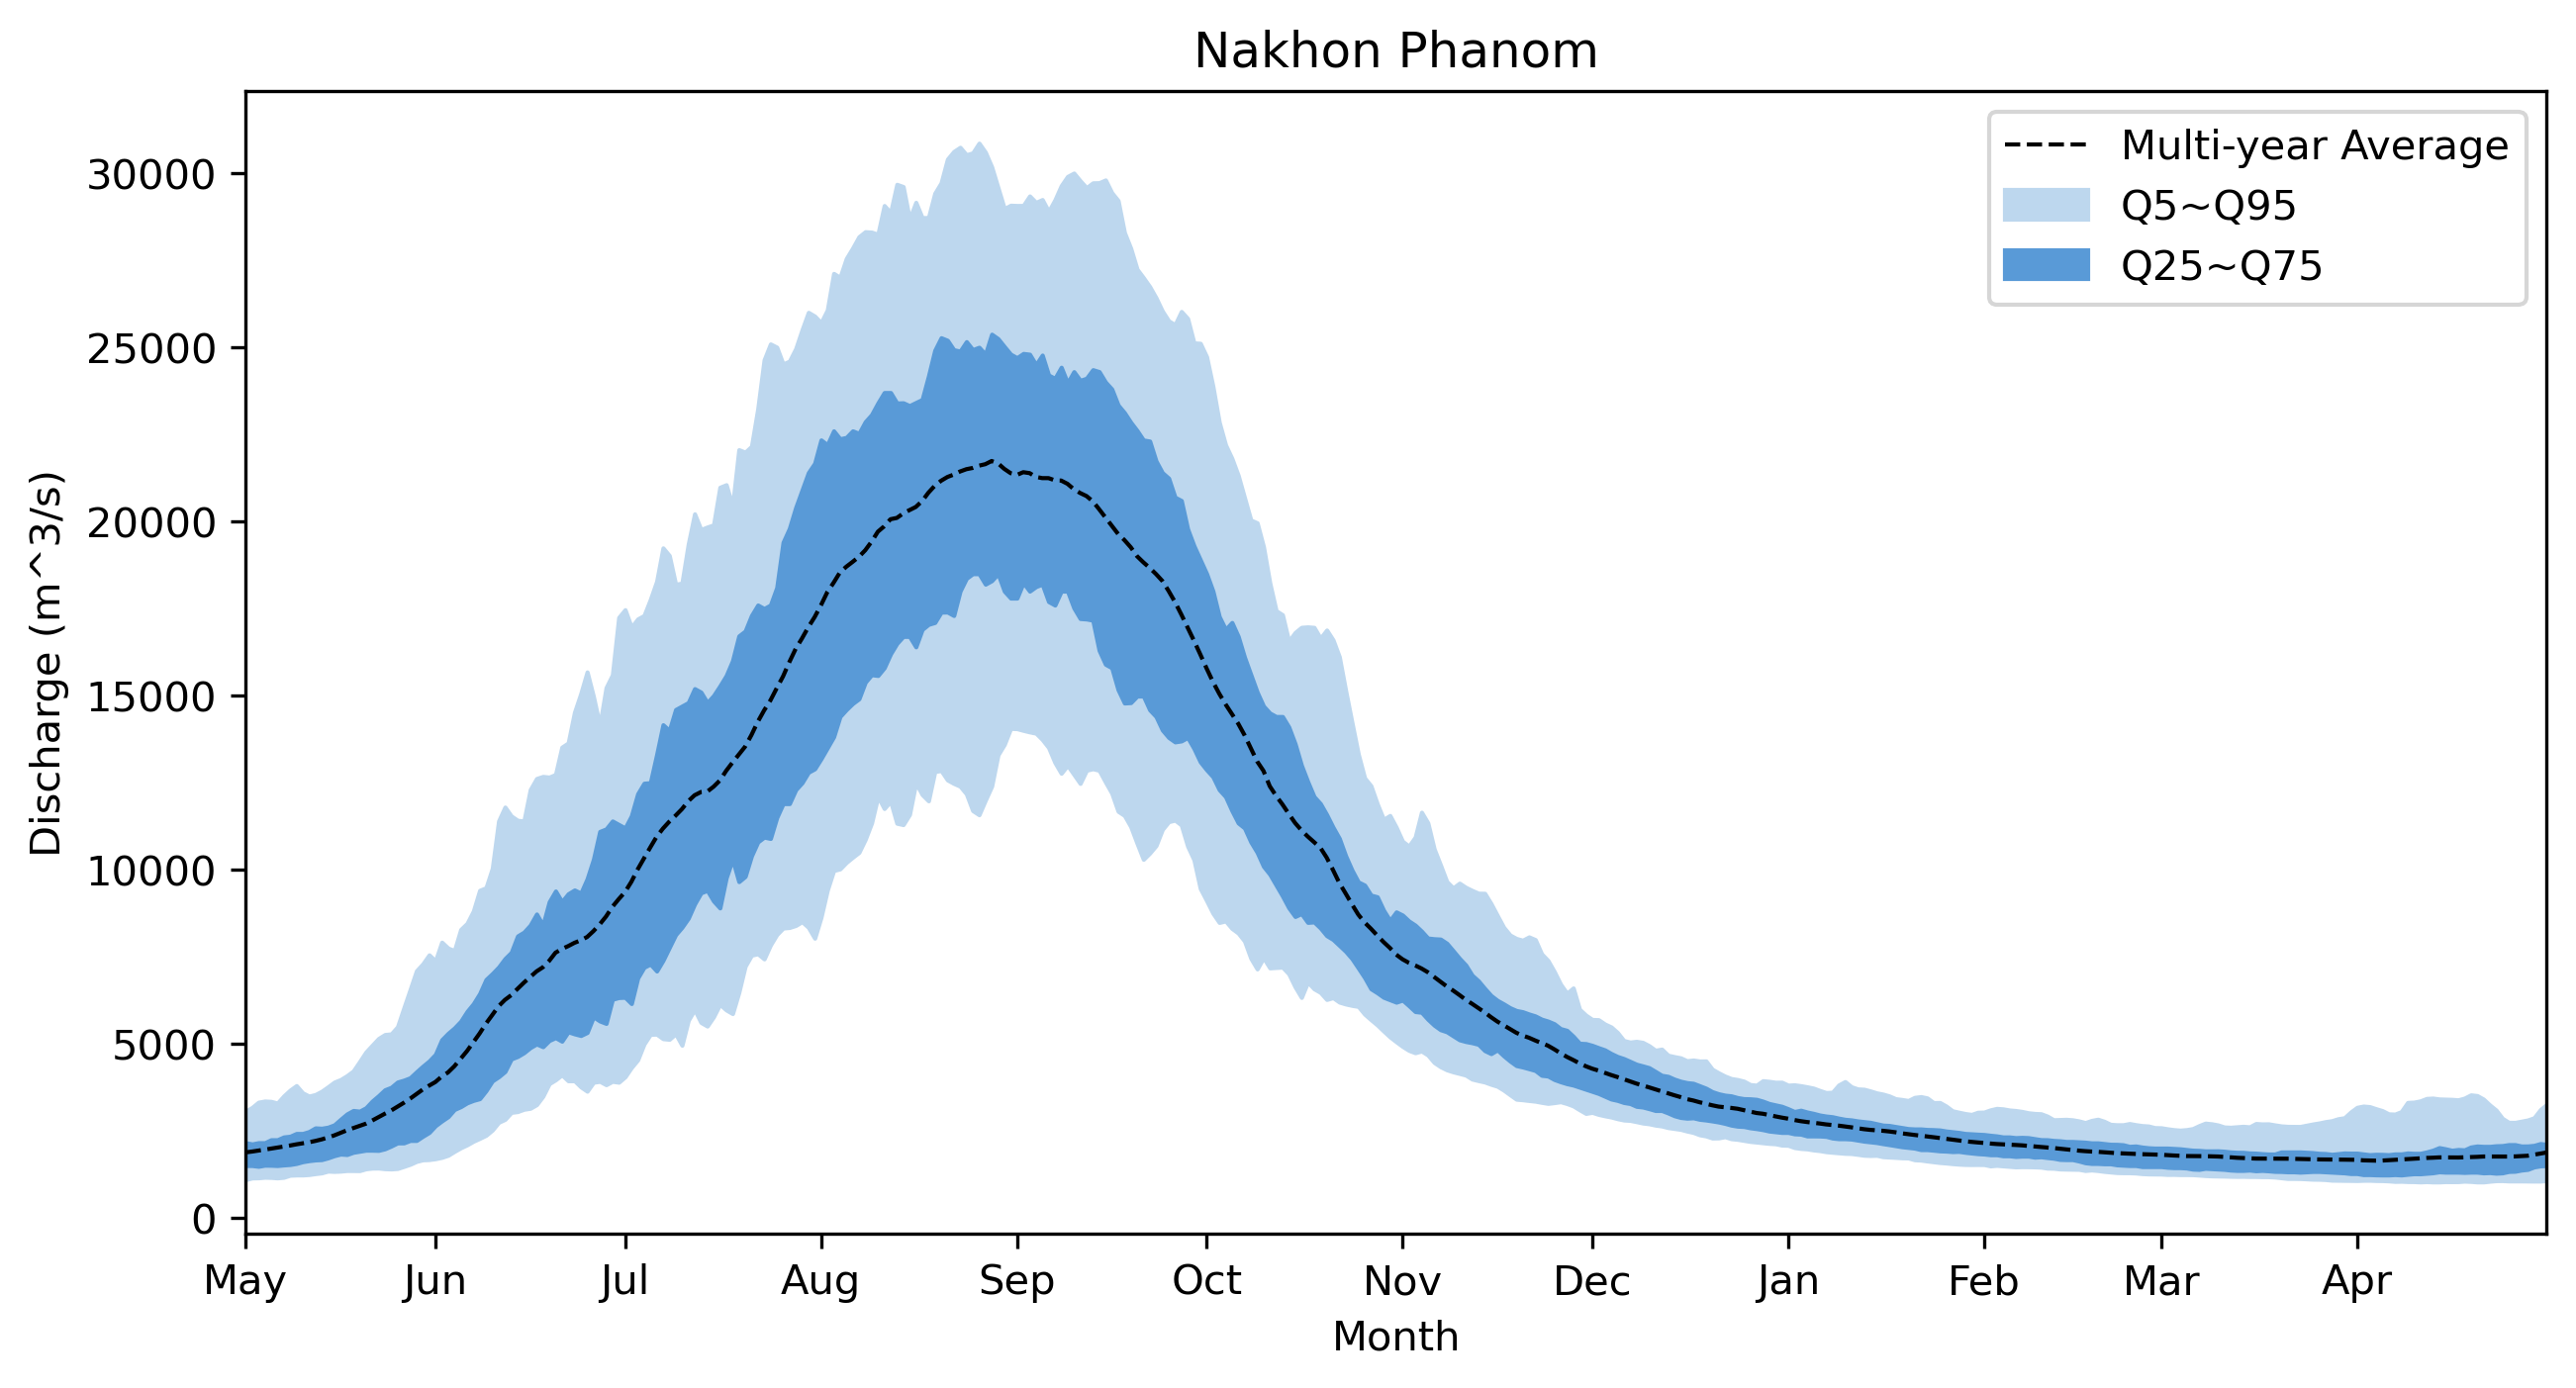

Nong Khai.csv


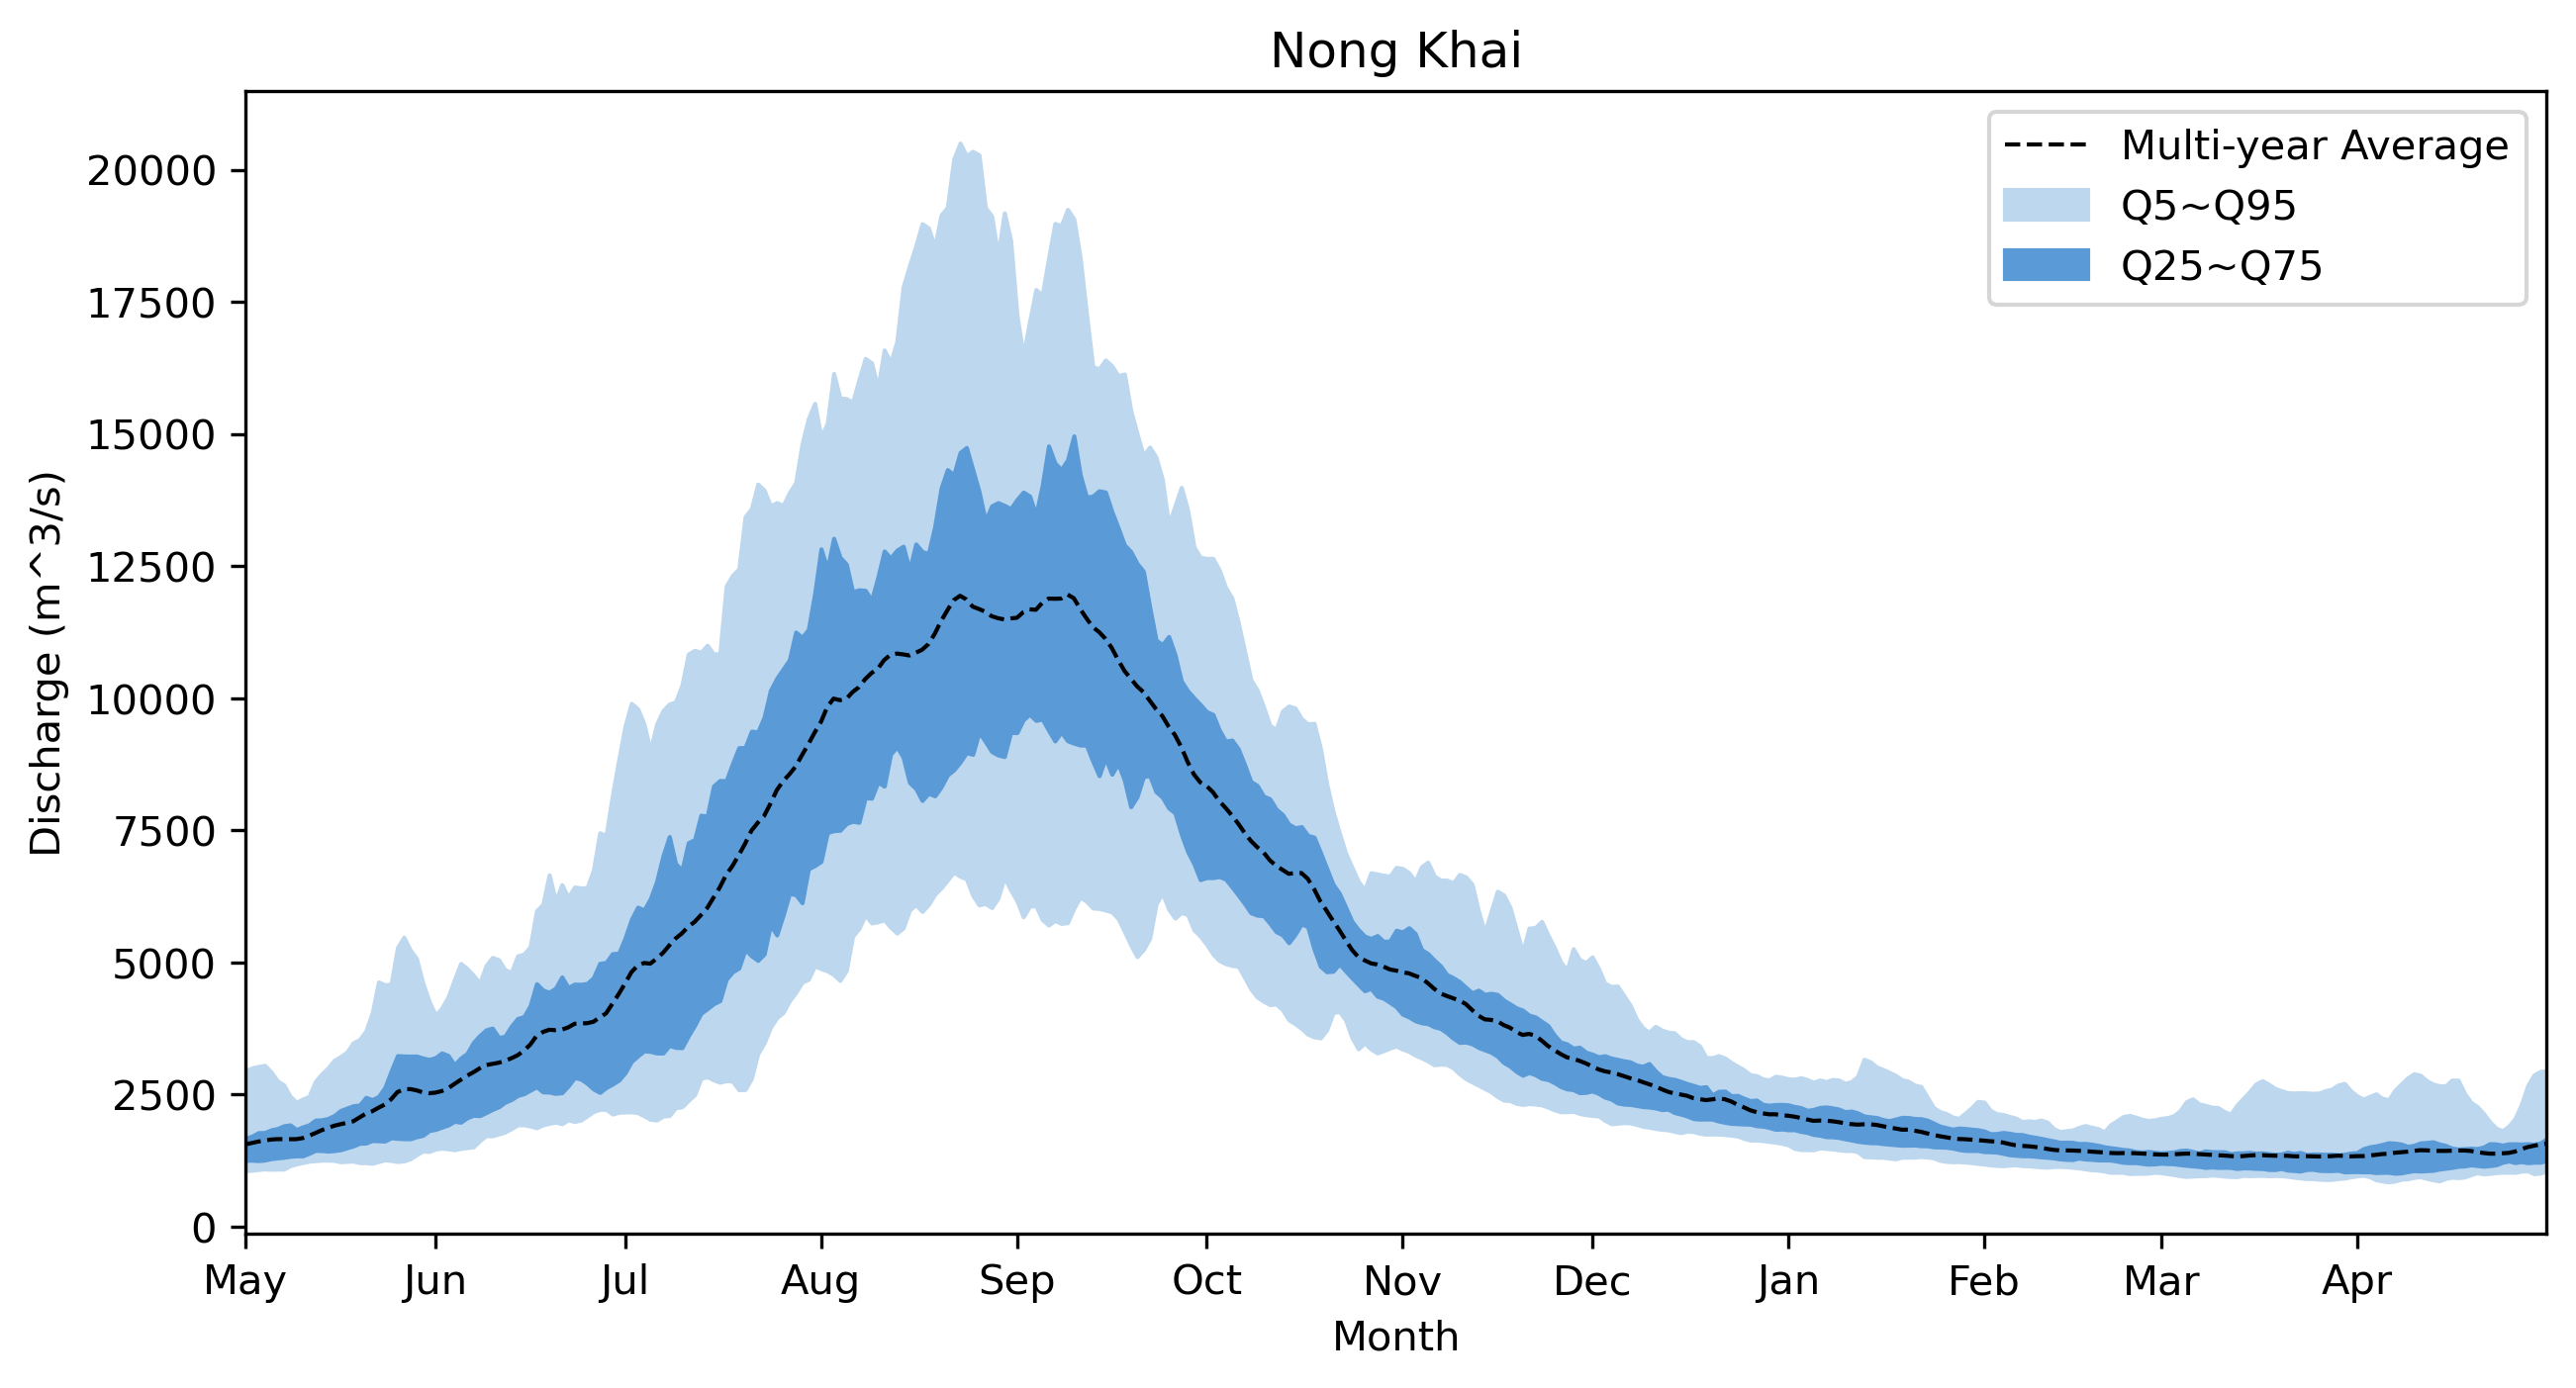

Pakse.csv


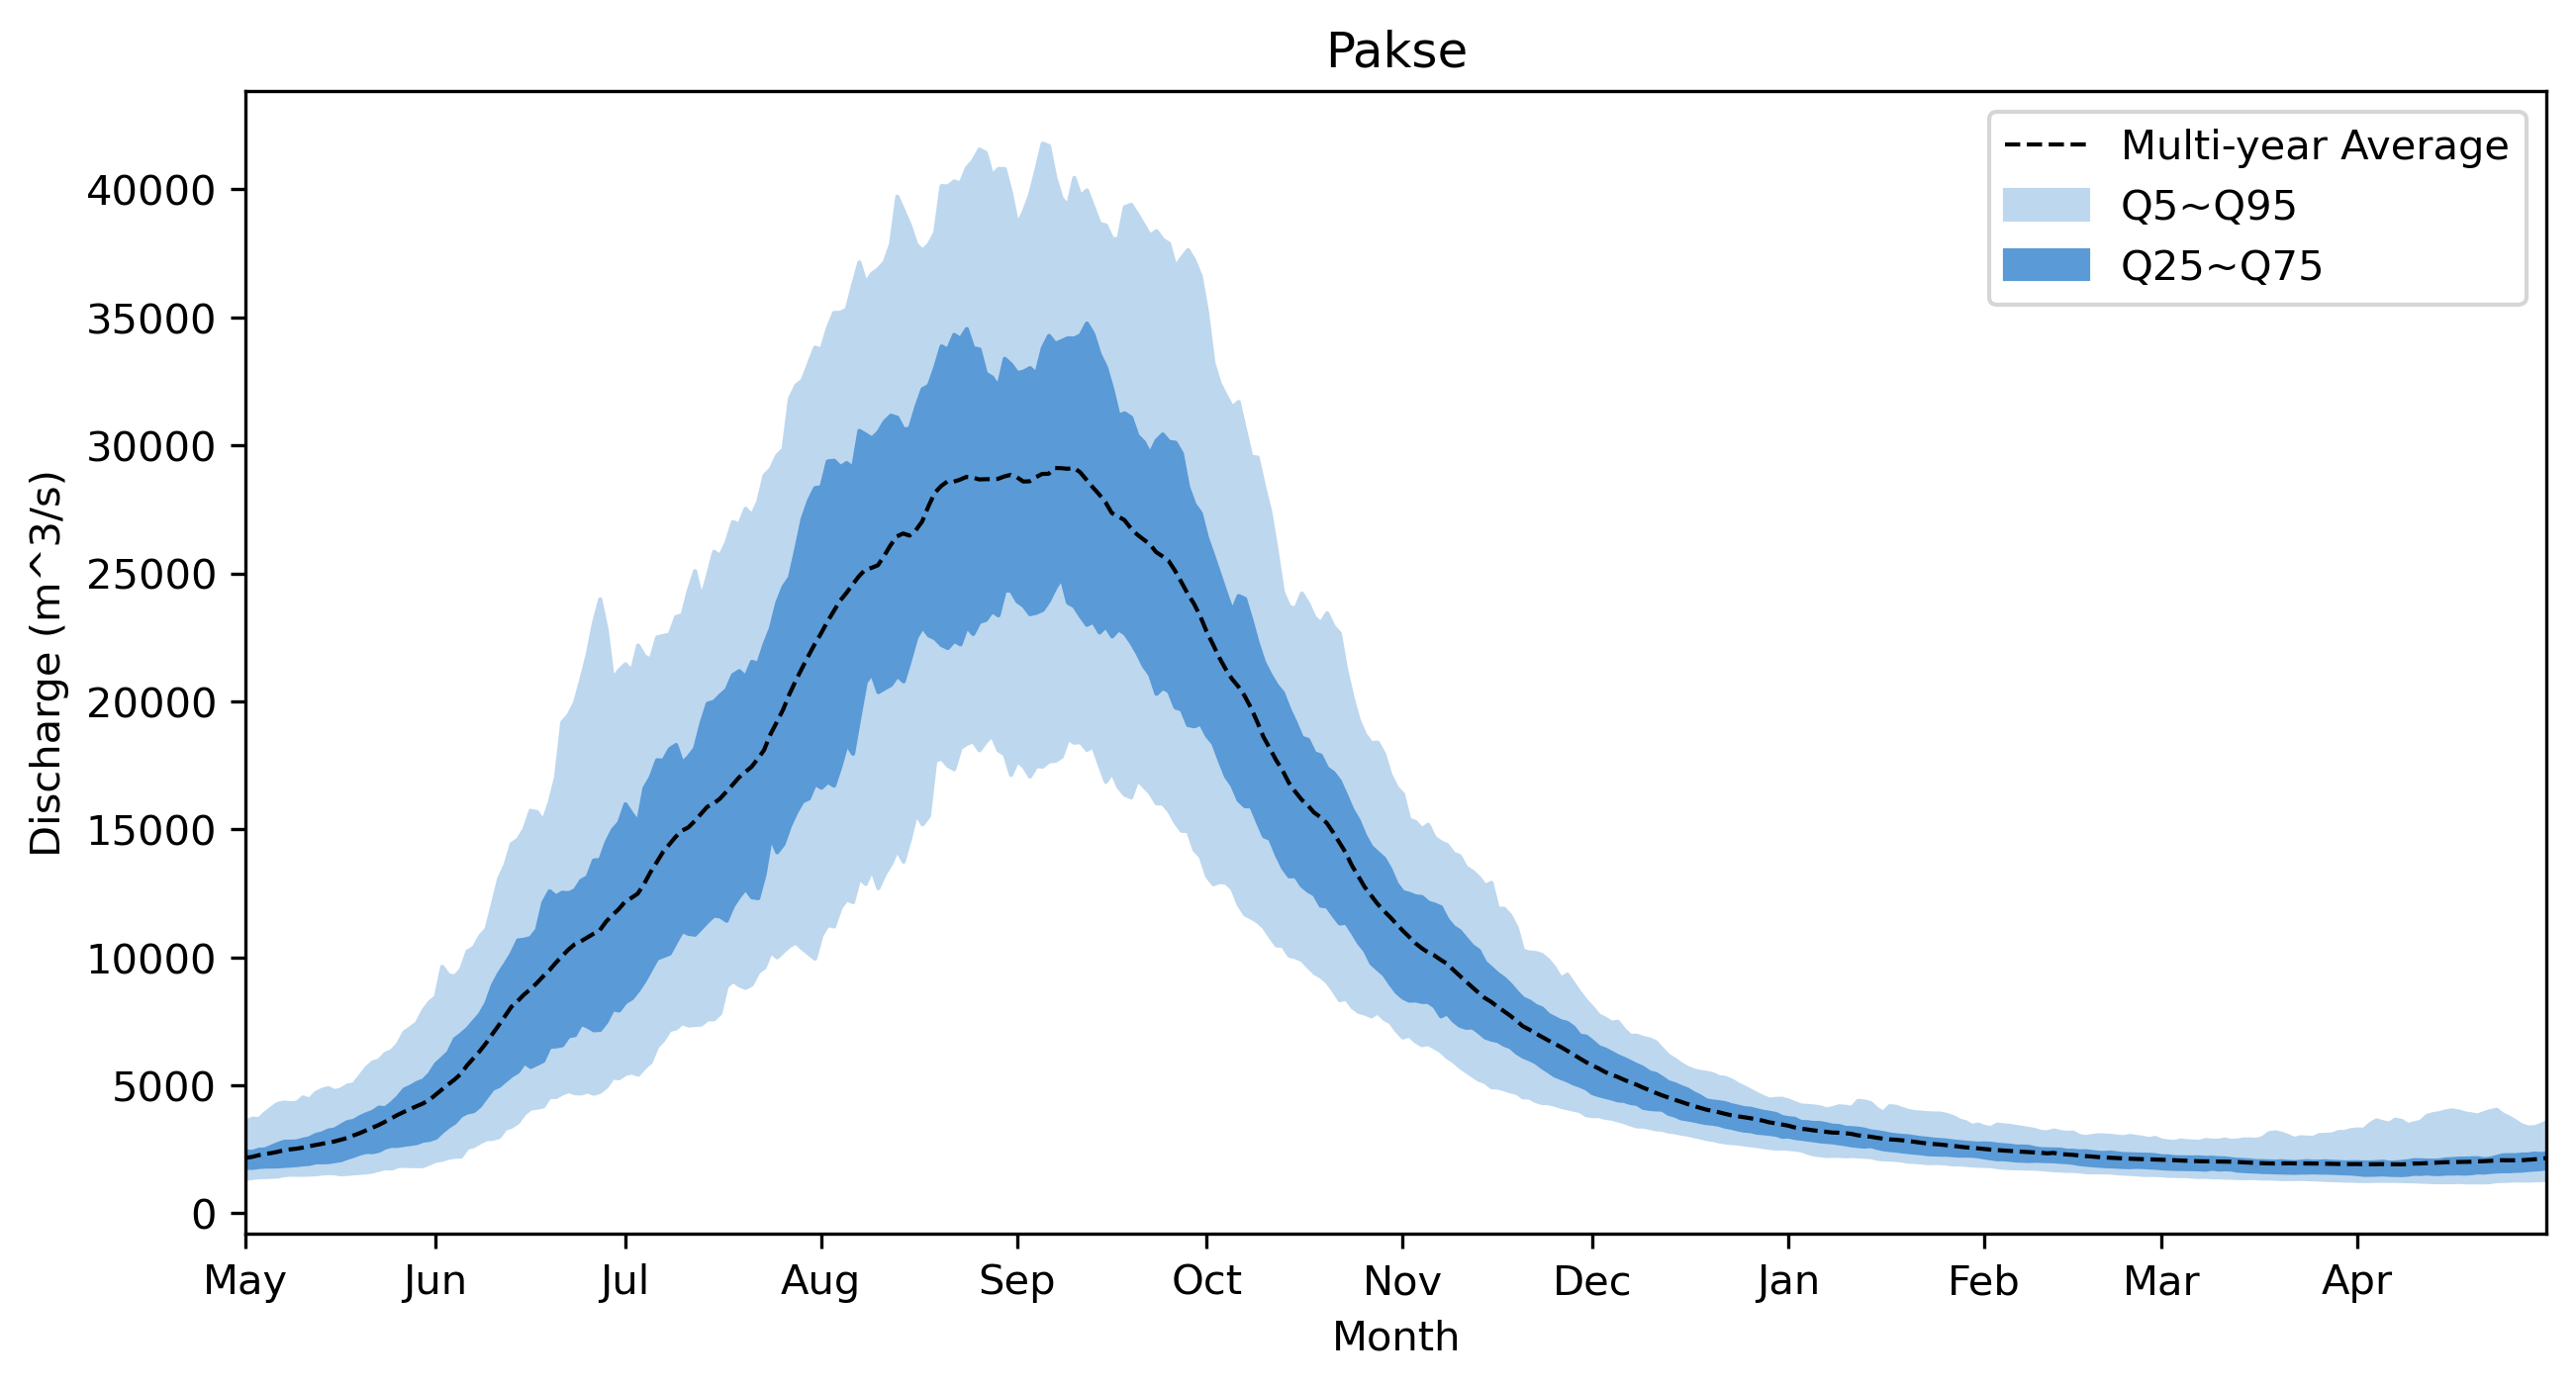

Stung Treng.csv


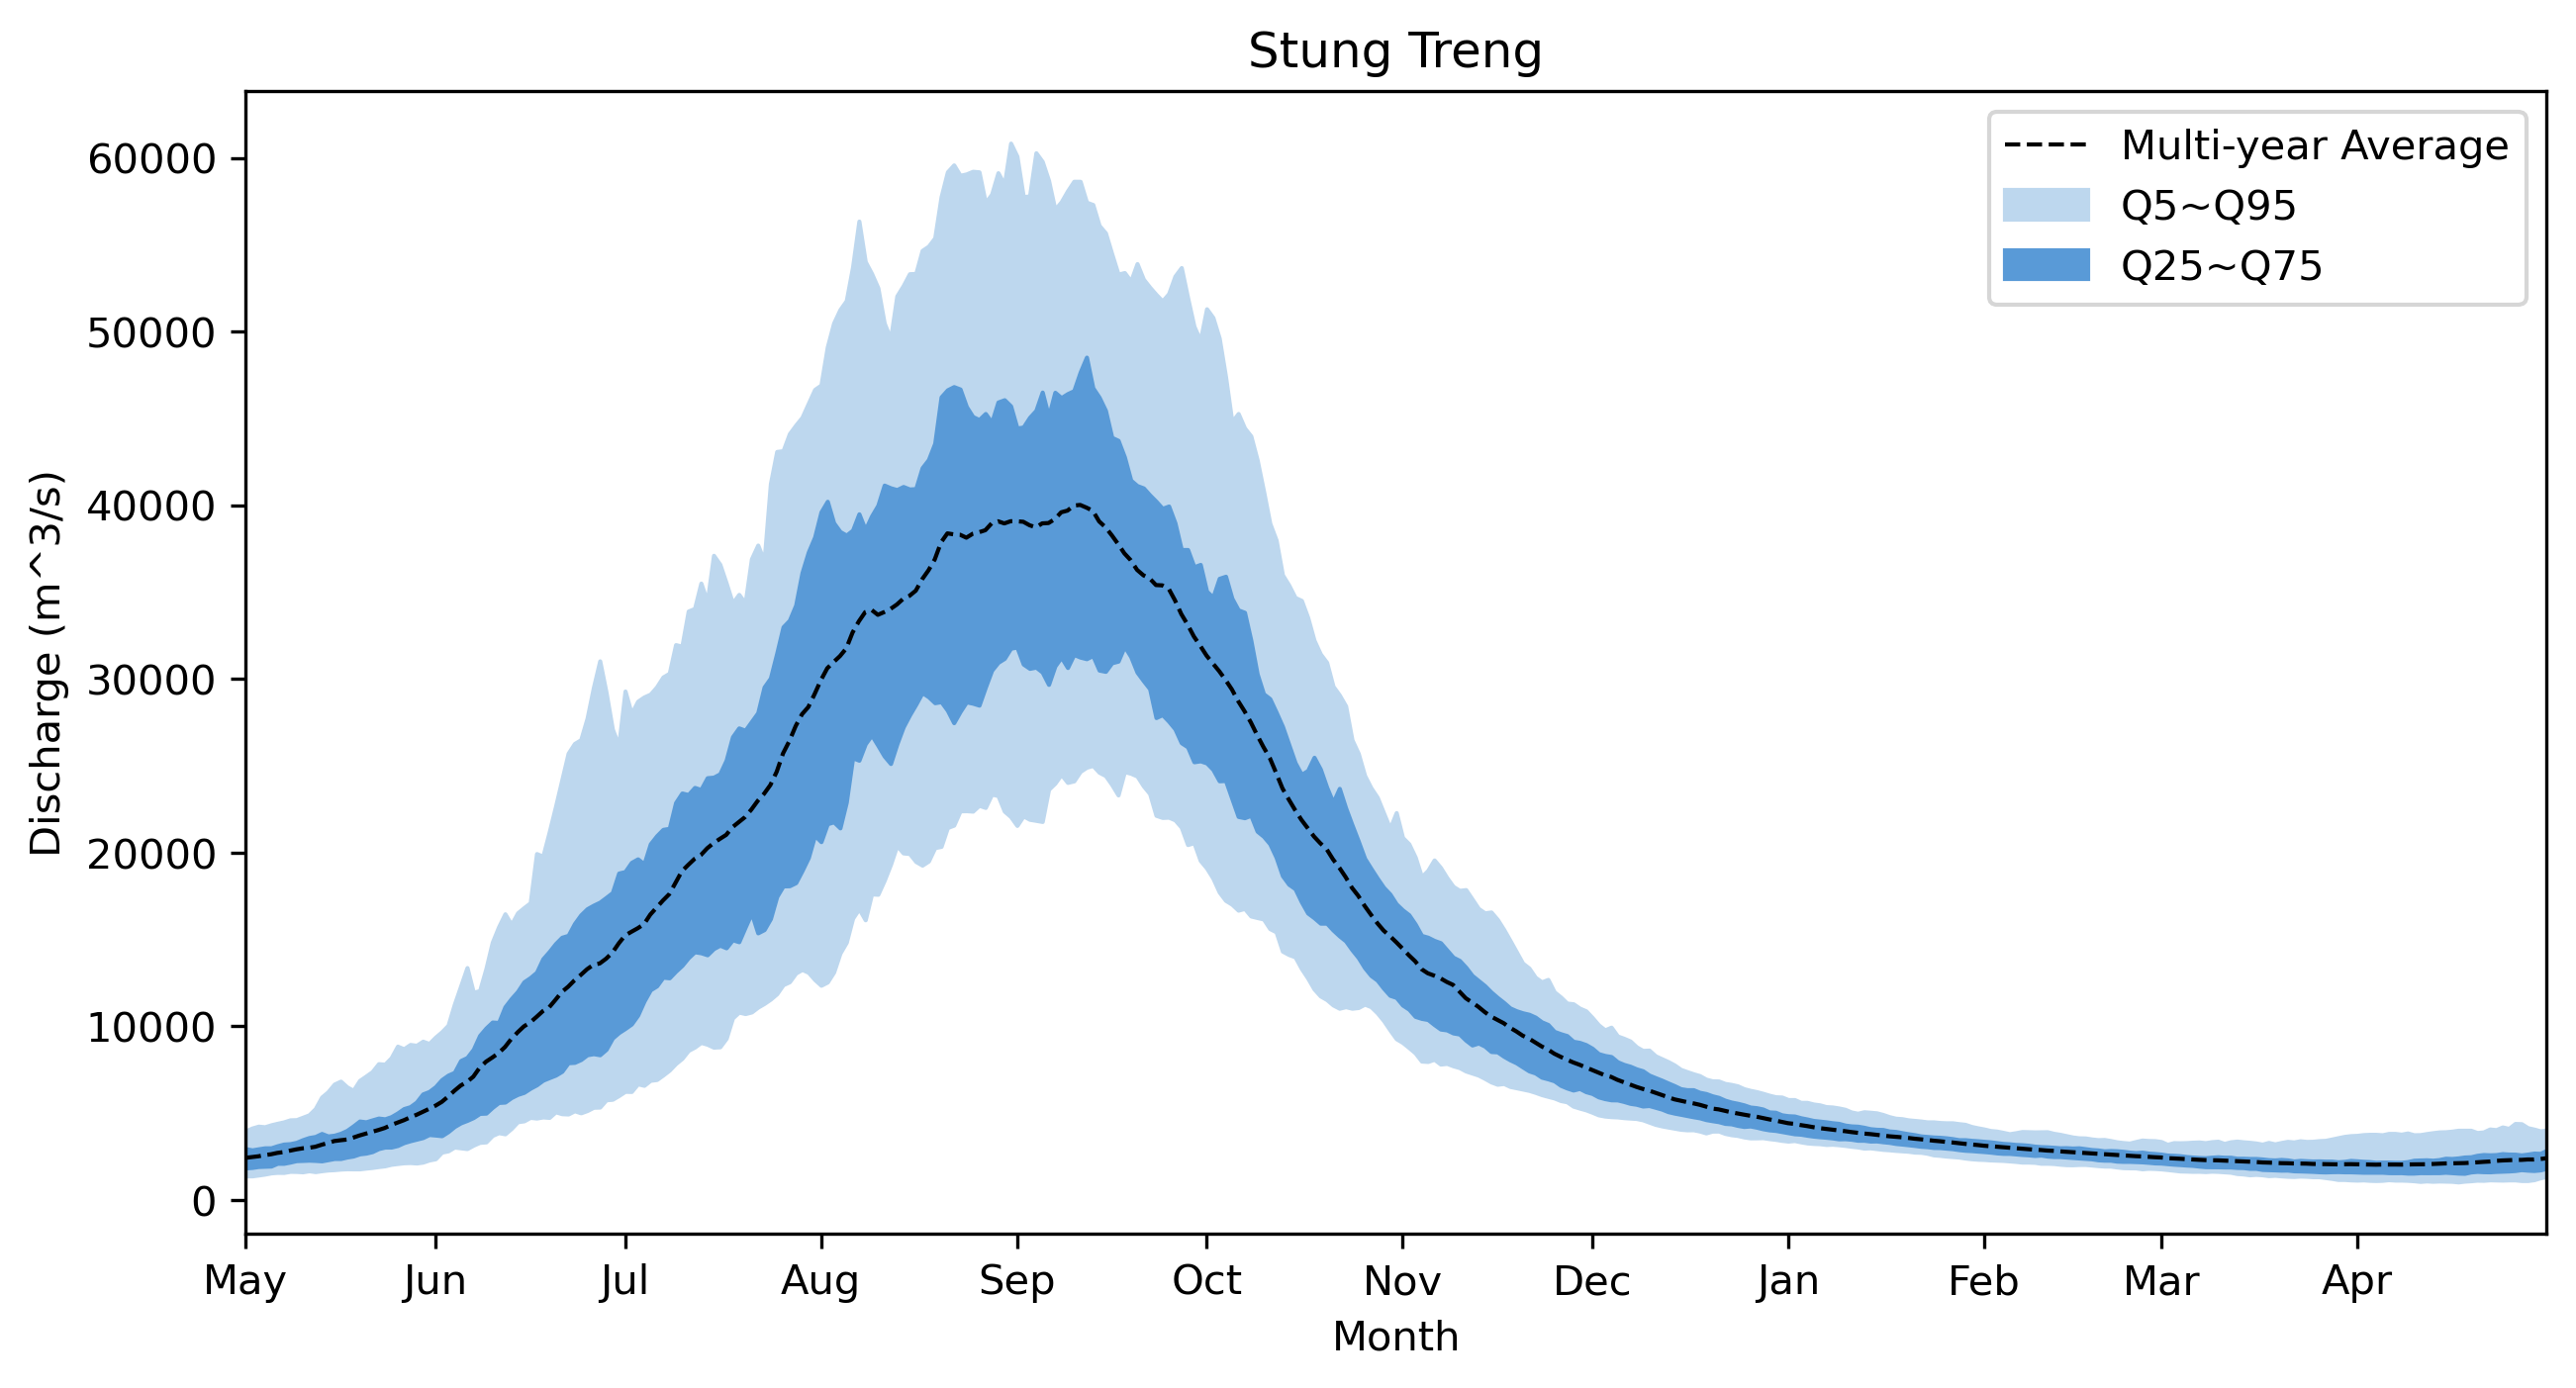

In [75]:
for f in filelist:
    if 'csv' in f:
        print(f)
        process_1file(f)

In [94]:
gauge

,Country_Co,Station_Co,Station_Na,lat,lon,time_span,geometry
0,TH,10501.0,Chiang Saen,20.274120,100.088547,19602021.0,POINT (100.08855 20.27412)
1,LA,11201.0,Luang Prabang,19.892799,102.134178,19392018.0,POINT (102.13418 19.89280)
2,TH,11903.0,Chiang Khan,17.900261,101.669891,19672021.0,POINT (101.66989 17.90026)
3,TH,12001.0,Nong Khai,17.881439,102.732201,19692021.0,POINT (102.73220 17.88144)
4,TH,13101.0,Nakhon Phanom,17.425369,104.773933,19242021.0,POINT (104.77393 17.42537)
5,TH,13402.0,Mukdahan,16.582800,104.733177,19232021.0,POINT (104.73318 16.58280)
6,TH,13801.0,Khong Chiam,15.322090,105.493477,19662021.0,POINT (105.49348 15.32209)
7,LA,13901.0,Pakse,15.099760,105.813187,19232021.0,POINT (105.81319 15.09976)
8,KH,14501.0,Stung Treng,13.532500,105.950188,19102021.0,POINT (105.95019 13.53250)
9,KH,14901.0,Kratie,12.481410,106.017616,19242021.0,POINT (106.01762 12.48141)


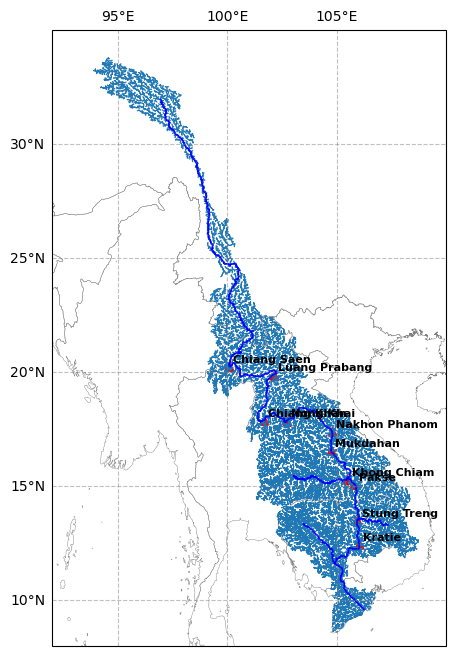

In [101]:
gauge = gpd.read_file('D:/LMRB/discharge/MRC/gauge.shp')
countries = gpd.read_file('D:/LMRB/wb_countries_admin0_10m_china/wb_countries_admin0_10m/WB_countries_Admin0_10m_area.shp')
mainstream = gpd.read_file('D:/LMRB/GRADES-HYDRODL/pfaf_level_02/lmrb.shp')
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_facecolor('none')
# plt.subplots_adjust(wspace=0.02)  # Adjust these values as needed

countries.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.3)
mainstream_1 = mainstream[mainstream['order_'] <6 ]
mainstream_1.plot(ax=ax, facecolor='none', edgecolor='tab:blue', linewidth=0.8)
mainstream_6 = mainstream[mainstream['order_'] >= 6]
mainstream_6.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2)
gauge.plot(ax=ax, color='red', marker='^', markersize=40)
for x, y, label in zip(gauge.geometry.x, gauge.geometry.y, gauge['Station_Na']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='black', fontweight='bold')
    
extent = [92, 110, 8, 35]
ax.set_extent(extent, crs=projection)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([95,100,105])
gl.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])